# Advanced Lane Detection

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from pylab import savefig
%matplotlib inline

## Camera Calibration

In [2]:

objectPoints = np.zeros((6*9,3), np.float32)
objectPoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# prepare object points
nx = 9
ny = 6

# Make a list of calibration images
imageList = []
undistortedImages = []
cornersList = []
objectPointsList = []

for filename in os.listdir("camera_cal/"):
    if filename.endswith(".jpg"):
        image = mpimg.imread(os.path.join("camera_cal/", filename))
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imageList.append(image)
            cornersList.append(corners)
            objectPointsList.append(objectPoints)
            # Draw and display the corners
#             cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
#             plt.imshow(image)
#             plt.figure()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPointsList, cornersList, gray.shape[::-1], None, None)

for image in imageList:
    dst = cv2.undistort(image, mtx, dist, None, mtx)
#     plt.imshow(dst)
#     plt.figure()
    undistortedImages.append(dst)

#Save and display the Images
cv2.imwrite('output_images/UndistortedChessBoard.jpg',undistortedImages[5])
cv2.imwrite('output_images/distortedChessBoard.jpg',imageList[5])


True

In [3]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [4]:
import math

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [5]:
# Load our image



def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = int(leftx_current - (margin))   # Update this
        win_xleft_high = int(leftx_current + (margin))  # Update this
        win_xright_low = int(rightx_current - (margin))  # Update this
        win_xright_high = int(rightx_current + (margin))  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) &
        (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) & 
        (nonzeroy >= win_y_low ) & (nonzeroy <= win_y_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
       
        if(np.size(good_left_inds) > minpix):
            leftx_current = np.mean(nonzerox[good_left_inds])  
        if(np.size(good_right_inds) > minpix):
            rightx_current = np.mean(nonzerox[good_right_inds])
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow', linewidth = 1)
    plt.plot(right_fitx, ploty, color='yellow',linewidth = 1)
    LeftLine = np.vstack((left_fitx,ploty)).astype(np.int32).T
    RightLine = np.vstack((right_fitx,ploty)).astype(np.int32).T
    leftCombined = cv2.polylines(out_img,[LeftLine],False,(255,255,45),3)
    BothCombined = cv2.polylines(out_img,[RightLine],False,(255,255,45),3)
    
    return left_fitx, right_fitx, ploty, out_img, left_fit, right_fit





## Undistorting the Road Images

## Transforming The Image Perspective

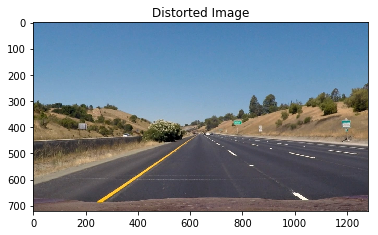

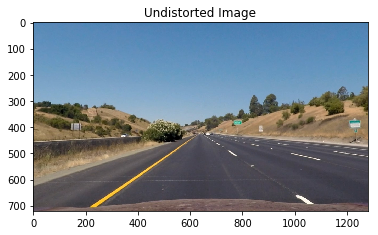

In [6]:
imagePath = 'test_images/straight_lines1.jpg'
originalImage = mpimg.imread(imagePath)
cv2Image = cv2.imread(imagePath)
dst = cv2.undistort(originalImage, mtx, dist, None, mtx)
plt.imshow(originalImage)
plt.title('Distorted Image')
plt.figure()
plt.title('Undistorted Image')
plt.imshow(dst)
# Save the images
# cv2.imwrite('output_images/sampleRoadOriginal.jpg',originalImage)
# cv2.imwrite('output_images/sampleRoadCorrected.jpg',dst)


In [7]:
def PerspectiveTransform(img,corners = None,unwarp = False):
        src = np.float32([[-160, 720],[505, 470],[765, 470],[1380, 720]])
        dst = np.float32([[0, 720],[0, 0],[1280, 0],[1280, 720]])
        if not unwarp:
                pass
        elif(unwarp):
            temp = dst
            dst = src
            src = temp            
        M = cv2.getPerspectiveTransform(src,dst)
        warped = cv2.warpPerspective(img,M,(1280,720),flags=cv2.INTER_LINEAR)
        
        return warped

In [8]:
imagePath = 'test_images/test6.jpg'
originalImage = mpimg.imread(imagePath)
# vertices = np.array([[(15,720),(575, 450), (735, 450), (1280,720)]], dtype=np.int32)
# image = region_of_interest(originalImage,vertices)
# plt.imshow(image)

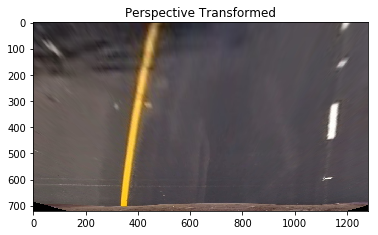

In [9]:
image = PerspectiveTransform(originalImage)
plt.imshow(image)
plt.title('Perspective Transformed')
plt.imsave('output_images/perspectiveTransform.jpg',image,format = 'jpg')

## Masking the Image using Thresholds

In [10]:
def thresholds(img,thresh_min,thresh_max):
    
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh_min) & (img <= thresh_max)] = 255
    
    return binary_output

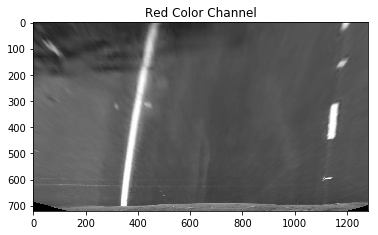

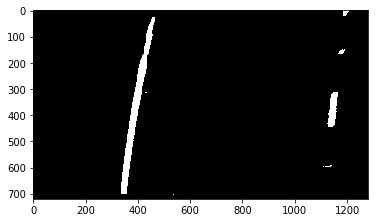

In [11]:
hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
plt.imshow(image[:,:,0],cmap = 'gray')
plt.title('Red Color Channel')
plt.imsave('output_images/RedColorChannel.jpg',image[:,:,0],cmap = 'gray',format = 'jpg')
plt.figure()
plt.imshow(thresholds(image[:,:,0],180,255),cmap = 'gray')

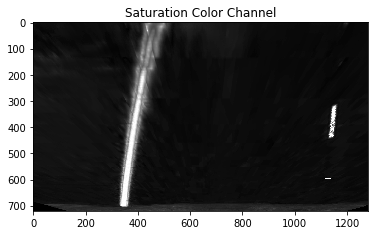

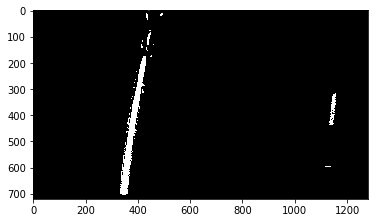

In [12]:
plt.imshow(hls[:,:,2],cmap = 'gray')
plt.title('Saturation Color Channel')
plt.imsave('output_images/SaturationColorChannel.jpg',image[:,:,0],cmap = 'gray',format = 'jpg')
plt.figure()
plt.imshow(thresholds(hls[:,:,2],150,255),cmap = 'gray')
plt.figure()




## Undistort the image now

82.2614919704861


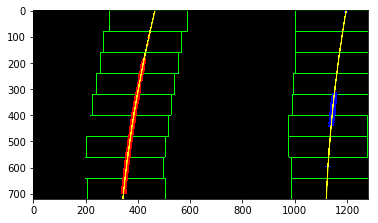

In [13]:
binary_warped = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
print(np.mean(binary_warped))
binary_warped = thresholds(image[:,:,0],220,255)
left_fitx, right_fitx, ploty, result, left_fit, right_fit = fit_polynomial(binary_warped)
plt.imshow(result)
plt.imsave('output_images/polyfitlines.jpg',result,format = 'jpg')

In [14]:
def measure_curvature_real(ploty,leftx,rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curverad = (1+(2*left_fit_cr[0]*720*ym_per_pix + left_fit_cr[1])**2)**1.5 / abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit_cr[0]*720*ym_per_pix + right_fit_cr[1])**2)**1.5 / abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad



In [30]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def fit_poly_general(img_shape, x, y):
    fit = np.polyfit(y, x, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    return fitx, ploty,fit

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # The width of the margin around the previous polynomial to search
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Sets the area of search based on activated x-values
    # within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, ploty, result, left_fit, right_fit

def search_around_poly_general(binary_warped, fit):
    # HYPERPARAMETER
    # The width of the margin around the previous polynomial to search
    margin = 15

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Sets the area of search based on activated x-values
    # within the +/- margin of our polynomial function 
    inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + 
                    fit[2] - margin)) & (nonzerox < (fit[0]*(nonzeroy**2) + 
                    fit[1]*nonzeroy + fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    x = nonzerox[inds]
    y = nonzeroy[inds] 

    # Fit new polynomials
    fitx, ploty, fit = fit_poly_general(binary_warped.shape, x, y)
    # Calculate the radius of curvature in meters for both lane lines
    curverad, curverad_second = measure_curvature_real(y,x,x)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[inds], nonzerox[inds]] = [255, 0, 0]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, 
                              ploty])))])
    pts = np.hstack((line_window1, line_window2))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return fitx, ploty, result, fit, curverad

In [40]:
def ProcessImage(image):    
        global left_fit
        global right_fit
        global first_window
        global mtx
        global dist
        xm_per_pix = 3.7/700
        image = cv2.undistort(image, mtx, dist, None, mtx)
        hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        aerialViewLeft = PerspectiveTransform(hls[:,:,2])
        aerialViewRight = PerspectiveTransform(image[:,:,0])
        minThreshRight = (np.mean(aerialViewLeft))*6
#         print(minThreshRight)
        if(minThreshRight > 240):
            minThreshRight = 230
#         minThreshRight = (np.mean(aerialViewRight)*300)**0.48
#         minThreshRight = 220
        minThreshLeft = 150
        binaryLeft = thresholds(aerialViewLeft,minThreshLeft,255)
        binaryRight = thresholds(aerialViewRight,minThreshRight,255)
        black_img = np.zeros_like(image)
        
        if(first_window):
            first_window = False
            left_fitx, right_fitx, ploty, out_img, left_fit_new, right_fit_new = fit_polynomial(binaryRight)
            curverad_left = 0
            curverad_right = 0
        else:
            left_fitx, ploty, result, left_fit_new, curverad_left = search_around_poly_general(binaryLeft,left_fit)
            right_fitx, ploty, result, right_fit_new, curverad_right = search_around_poly_general(binaryRight,right_fit)
            
        LeftLine = np.vstack((left_fitx,ploty)).astype(np.int32).T
        RightLine = np.vstack((right_fitx,ploty)).astype(np.int32).T
        LeftCombined = cv2.polylines(black_img,[LeftLine],False,(0,160,160),50)
        BothCombined = cv2.polylines(black_img,[RightLine],False,(0,160,160),50)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])

        right_line_window1 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        lane_pts = np.hstack((left_line_window1, right_line_window1))
        # Draw the lane onto the warped blank image
        BothCombined = cv2.fillPoly(BothCombined, np.int_(lane_pts), (0,150, 0,230))
        unwarpedWithLines = PerspectiveTransform(BothCombined,unwarp = True)
        finalImage = weighted_img(image,unwarpedWithLines)
        left_fit = left_fit_new
        right_fit = right_fit_new
        curvature_ave = (curverad_left + curverad_right) / 2
        cv2.putText(finalImage, "Curvature = " + str(round(curvature_ave,0))+ ' m', (25, 50),  0, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        offset = ((left_fitx[-1] + right_fitx[-1]) / 2) - image.shape[1] / 2
        offsetMeters = offset*xm_per_pix
        if(offsetMeters > 0):
            cv2.putText(finalImage, str(round(offsetMeters,2))+ ' m left of center', (25, 90),  0, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        elif(offsetMeters < 0):
            cv2.putText(finalImage, str(round(abs(offsetMeters),2))+ ' m right of center', (25, 90),  0, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        return  finalImage

126.43354817708334
126.43354817708334


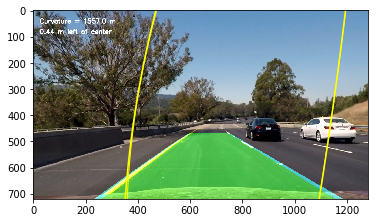

In [41]:

plt.figure()
first_window = True
finalShowImage = ProcessImage(originalImage)
plt.imshow(finalShowImage)
finalShowImage = ProcessImage(originalImage)
plt.imshow(finalShowImage)
plt.imsave('output_images/finalResult.jpg',finalShowImage,format = 'jpg')

112.35638671875
[MoviePy] >>>> Building video final_output_video.mp4
[MoviePy] Writing video final_output_video.mp4









  0%|          | 0/1261 [00:00<?, ?it/s]

112.35638671875









  0%|          | 1/1261 [00:00<02:11,  9.55it/s]

112.41655598958334









  0%|          | 2/1261 [00:00<02:27,  8.56it/s]

113.53559244791666









  0%|          | 4/1261 [00:00<02:13,  9.38it/s]

115.19702473958333
115.55153645833335
115.759921875









  0%|          | 6/1261 [00:00<02:09,  9.72it/s]

116.17771484375001
115.19593098958333








  1%|          | 8/1261 [00:00<02:08,  9.74it/s]








  1%|          | 9/1261 [00:00<02:08,  9.74it/s]

116.04283203125









  1%|          | 10/1261 [00:01<02:09,  9.64it/s]

116.69662760416666









  1%|          | 11/1261 [00:01<02:10,  9.56it/s]

117.51999348958334









  1%|          | 12/1261 [00:01<02:11,  9.51it/s]

118.566015625









  1%|          | 13/1261 [00:01<02:12,  9.39it/s]

119.41928385416668
120.14245442708334
120.74704427083334









  1%|          | 15/1261 [00:01<02:11,  9.49it/s]

119.92759765625









  1%|▏         | 16/1261 [00:01<02:11,  9.47it/s]






  1%|▏         | 17/1261 [00:01<02:10,  9.50it/s]

119.34532552083333









  1%|▏         | 18/1261 [00:01<02:12,  9.40it/s]

119.74419270833333
119.82591796875









  2%|▏         | 19/1261 [00:02<02:12,  9.34it/s]

120.64462239583332









  2%|▏         | 20/1261 [00:02<02:14,  9.23it/s]

121.03839192708332









  2%|▏         | 21/1261 [00:02<02:19,  8.89it/s]

121.85551432291666









  2%|▏         | 22/1261 [00:02<02:18,  8.92it/s]






  2%|▏         | 23/1261 [00:02<02:18,  8.92it/s]

121.02782552083333
118.74665364583333









  2%|▏         | 25/1261 [00:02<02:17,  9.02it/s]

116.74046223958334
116.3273046875









  2%|▏         | 26/1261 [00:02<02:16,  9.03it/s]






  2%|▏         | 28/1261 [00:03<02:15,  9.12it/s]

118.11878906249999
119.50180989583333
119.81611328124998









  2%|▏         | 29/1261 [00:03<02:14,  9.13it/s]






  2%|▏         | 31/1261 [00:03<02:13,  9.22it/s]

119.7817578125
116.58324869791667
114.48954427083333









  3%|▎         | 32/1261 [00:03<02:13,  9.22it/s]






  3%|▎         | 34/1261 [00:03<02:12,  9.29it/s]

113.69496744791667
113.27086588541667
113.40960286458333









  3%|▎         | 35/1261 [00:03<02:11,  9.31it/s]






  3%|▎         | 37/1261 [00:03<02:10,  9.36it/s]

114.34114583333334
113.13316406250001
113.37508463541667









  3%|▎         | 39/1261 [00:04<02:09,  9.42it/s]

113.93223958333334
113.97595052083332









  3%|▎         | 41/1261 [00:04<02:09,  9.43it/s]

113.89282552083334
114.68207682291667









  3%|▎         | 43/1261 [00:04<02:09,  9.41it/s]






  3%|▎         | 44/1261 [00:04<02:09,  9.39it/s]

113.29856770833334
113.39138020833333









  4%|▎         | 45/1261 [00:04<02:09,  9.38it/s]






  4%|▎         | 46/1261 [00:04<02:09,  9.39it/s]

112.58981119791666
112.67824218749999









  4%|▍         | 48/1261 [00:05<02:08,  9.42it/s]

113.21162760416667
112.32025390625
112.29920572916667









  4%|▍         | 49/1261 [00:05<02:08,  9.43it/s]






  4%|▍         | 50/1261 [00:05<02:08,  9.43it/s]

112.58359375
112.11024739583333
113.23745442708332









  4%|▍         | 52/1261 [00:05<02:07,  9.45it/s]






  4%|▍         | 53/1261 [00:05<02:07,  9.45it/s]






  4%|▍         | 54/1261 [00:05<02:07,  9.44it/s]

113.18873046875001
114.67050130208332









  4%|▍         | 55/1261 [00:05<02:07,  9.43it/s]






  4%|▍         | 56/1261 [00:05<02:07,  9.42it/s]

113.834453125
112.957734375









  5%|▍         | 57/1261 [00:06<02:08,  9.39it/s]

112.23449869791666
111.499453125









  5%|▍         | 58/1261 [00:06<02:08,  9.35it/s]






  5%|▍         | 59/1261 [00:06<02:10,  9.23it/s]

110.74151041666667
111.13538411458333









  5%|▍         | 60/1261 [00:06<02:10,  9.18it/s]






  5%|▍         | 61/1261 [00:06<02:10,  9.16it/s]

111.98140624999999
112.56139322916667









  5%|▍         | 62/1261 [00:06<02:11,  9.15it/s]






  5%|▍         | 63/1261 [00:06<02:11,  9.10it/s]

112.869765625
113.17267578125









  5%|▌         | 64/1261 [00:07<02:13,  8.98it/s]






  5%|▌         | 65/1261 [00:07<02:14,  8.91it/s]

113.4410546875
112.93762369791666









  5%|▌         | 66/1261 [00:07<02:14,  8.89it/s]






  5%|▌         | 67/1261 [00:07<02:14,  8.87it/s]

113.10451822916667
112.22406901041667









  5%|▌         | 68/1261 [00:07<02:14,  8.85it/s]






  5%|▌         | 69/1261 [00:07<02:14,  8.83it/s]

112.62187499999999
113.226796875









  6%|▌         | 70/1261 [00:07<02:14,  8.82it/s]






  6%|▌         | 71/1261 [00:08<02:15,  8.81it/s]

111.82675781249999
111.53136067708334









  6%|▌         | 72/1261 [00:08<02:15,  8.80it/s]






  6%|▌         | 73/1261 [00:08<02:15,  8.77it/s]

111.80190104166667
112.36069010416666









  6%|▌         | 74/1261 [00:08<02:16,  8.71it/s]






  6%|▌         | 75/1261 [00:08<02:17,  8.64it/s]

114.68625
114.89510416666667









  6%|▌         | 76/1261 [00:08<02:17,  8.60it/s]






  6%|▌         | 77/1261 [00:08<02:18,  8.57it/s]

113.52388020833334
115.4084765625









  6%|▌         | 78/1261 [00:09<02:18,  8.56it/s]






  6%|▋         | 79/1261 [00:09<02:19,  8.49it/s]

113.64261067708333
113.39738281249998









  6%|▋         | 80/1261 [00:09<02:19,  8.46it/s]






  6%|▋         | 81/1261 [00:09<02:20,  8.40it/s]

112.03527343750001









  7%|▋         | 82/1261 [00:09<02:22,  8.30it/s]

113.20264322916665
111.20641927083335









  7%|▋         | 83/1261 [00:10<02:22,  8.26it/s]






  7%|▋         | 84/1261 [00:10<02:23,  8.20it/s]

111.12369791666666
110.43111979166667









  7%|▋         | 85/1261 [00:10<02:23,  8.18it/s]






  7%|▋         | 86/1261 [00:10<02:23,  8.17it/s]








110.37567708333333
109.79216796875001


  7%|▋         | 87/1261 [00:10<02:23,  8.17it/s]






  7%|▋         | 88/1261 [00:10<02:24,  8.14it/s]

109.93486328125
108.64436197916666









  7%|▋         | 89/1261 [00:11<02:25,  8.07it/s]






  7%|▋         | 90/1261 [00:11<02:25,  8.05it/s]

108.52589192708334
108.49394531249999









  7%|▋         | 91/1261 [00:11<02:27,  7.93it/s]






  7%|▋         | 92/1261 [00:11<02:28,  7.90it/s]

109.01296223958333
108.41259114583333









  7%|▋         | 93/1261 [00:11<02:28,  7.87it/s]






  7%|▋         | 94/1261 [00:11<02:28,  7.88it/s]

107.62971354166667
106.37802734375









  8%|▊         | 95/1261 [00:12<02:28,  7.88it/s]






  8%|▊         | 96/1261 [00:12<02:27,  7.88it/s]






  8%|▊         | 97/1261 [00:12<02:27,  7.89it/s]

106.03861328125001
106.85808593750001









  8%|▊         | 98/1261 [00:12<02:27,  7.87it/s]

107.99353515625
108.9862890625









  8%|▊         | 99/1261 [00:12<02:27,  7.87it/s]






  8%|▊         | 100/1261 [00:12<02:27,  7.86it/s]

110.57992838541665
109.9708203125









  8%|▊         | 101/1261 [00:12<02:27,  7.84it/s]






  8%|▊         | 102/1261 [00:13<02:27,  7.83it/s]

109.40324869791667
108.28575520833333









  8%|▊         | 103/1261 [00:13<02:28,  7.82it/s]






  8%|▊         | 104/1261 [00:13<02:28,  7.80it/s]

109.69297526041666
110.99113932291667









  8%|▊         | 105/1261 [00:13<02:28,  7.76it/s]






  8%|▊         | 106/1261 [00:13<02:29,  7.75it/s]

108.70412760416667
110.6639453125









  8%|▊         | 107/1261 [00:13<02:29,  7.71it/s]






  9%|▊         | 108/1261 [00:14<02:29,  7.71it/s]

108.23298177083333
107.649296875









  9%|▊         | 109/1261 [00:14<02:29,  7.68it/s]






  9%|▊         | 110/1261 [00:14<02:30,  7.67it/s]

107.32284505208332
108.36118489583333









  9%|▉         | 111/1261 [00:14<02:30,  7.65it/s]






  9%|▉         | 112/1261 [00:14<02:30,  7.63it/s]

111.06037109375
112.23163411458333









  9%|▉         | 113/1261 [00:14<02:30,  7.62it/s]






  9%|▉         | 114/1261 [00:14<02:30,  7.62it/s]

110.08326822916666
110.72065755208334









  9%|▉         | 115/1261 [00:15<02:30,  7.60it/s]






  9%|▉         | 116/1261 [00:15<02:30,  7.59it/s]

109.77233723958335
109.60146484375









  9%|▉         | 117/1261 [00:15<02:31,  7.57it/s]






  9%|▉         | 118/1261 [00:15<02:31,  7.56it/s]

109.50046223958333
110.58394531249999









  9%|▉         | 119/1261 [00:15<02:31,  7.53it/s]






 10%|▉         | 120/1261 [00:15<02:31,  7.52it/s]

108.45427734375
106.69109375000001









 10%|▉         | 121/1261 [00:16<02:31,  7.51it/s]






 10%|▉         | 122/1261 [00:16<02:31,  7.50it/s]

106.82613281249999
107.18981119791667









 10%|▉         | 123/1261 [00:16<02:31,  7.49it/s]






 10%|▉         | 124/1261 [00:16<02:32,  7.48it/s]

107.31741536458333
107.63632161458332









 10%|▉         | 125/1261 [00:16<02:32,  7.47it/s]






 10%|▉         | 126/1261 [00:16<02:32,  7.46it/s]

107.48654296875
108.56711588541668









 10%|█         | 127/1261 [00:17<02:32,  7.44it/s]






 10%|█         | 128/1261 [00:17<02:32,  7.43it/s]

109.52927083333334
110.28636718749999









 10%|█         | 129/1261 [00:17<02:32,  7.42it/s]






 10%|█         | 130/1261 [00:17<02:32,  7.40it/s]

110.36545572916665
110.74570963541666









 10%|█         | 131/1261 [00:17<02:32,  7.39it/s]






 10%|█         | 132/1261 [00:17<02:33,  7.37it/s]

111.54328776041666
110.09635416666666









 11%|█         | 133/1261 [00:18<02:33,  7.36it/s]






 11%|█         | 134/1261 [00:18<02:33,  7.36it/s]

110.0975390625
111.15164713541665









 11%|█         | 135/1261 [00:18<02:33,  7.36it/s]






 11%|█         | 136/1261 [00:18<02:32,  7.36it/s]

112.06364583333334
112.55981770833334









 11%|█         | 137/1261 [00:18<02:32,  7.35it/s]






 11%|█         | 138/1261 [00:18<02:32,  7.35it/s]

113.2284375
114.60585286458334









 11%|█         | 139/1261 [00:18<02:32,  7.34it/s]






 11%|█         | 140/1261 [00:19<02:32,  7.34it/s]

115.59883463541667
115.93052734374999









 11%|█         | 141/1261 [00:19<02:32,  7.34it/s]






 11%|█▏        | 142/1261 [00:19<02:32,  7.32it/s]

117.38647786458334
117.25634765625









 11%|█▏        | 143/1261 [00:19<02:32,  7.31it/s]






 11%|█▏        | 144/1261 [00:19<02:32,  7.31it/s]

117.17188802083334
116.42500651041667









 11%|█▏        | 145/1261 [00:19<02:32,  7.31it/s]






 12%|█▏        | 146/1261 [00:19<02:32,  7.31it/s]

117.69939453125001
117.42527994791666









 12%|█▏        | 147/1261 [00:20<02:32,  7.29it/s]






 12%|█▏        | 148/1261 [00:20<02:32,  7.29it/s]

118.25993489583334
118.92544921875









 12%|█▏        | 149/1261 [00:20<02:32,  7.29it/s]






 12%|█▏        | 150/1261 [00:20<02:32,  7.29it/s]

120.29821614583332
120.11951822916666









 12%|█▏        | 151/1261 [00:20<02:32,  7.29it/s]






 12%|█▏        | 152/1261 [00:20<02:32,  7.29it/s]








120.92965494791667
118.49085286458333


 12%|█▏        | 153/1261 [00:20<02:31,  7.30it/s]






 12%|█▏        | 154/1261 [00:21<02:31,  7.29it/s]

117.65771484375
116.09748697916666









 12%|█▏        | 155/1261 [00:21<02:32,  7.27it/s]






 12%|█▏        | 156/1261 [00:21<02:32,  7.26it/s]

114.15684244791667
114.0773046875









 12%|█▏        | 157/1261 [00:21<02:32,  7.25it/s]






 13%|█▎        | 158/1261 [00:21<02:32,  7.25it/s]

113.85073567708334
112.54089192708335









 13%|█▎        | 159/1261 [00:21<02:32,  7.24it/s]






 13%|█▎        | 160/1261 [00:22<02:32,  7.24it/s]

112.37867838541666
113.14992187499999









 13%|█▎        | 161/1261 [00:22<02:32,  7.23it/s]






 13%|█▎        | 162/1261 [00:22<02:32,  7.21it/s]

113.47915364583332
113.69092447916668









 13%|█▎        | 163/1261 [00:22<02:32,  7.21it/s]






 13%|█▎        | 164/1261 [00:22<02:32,  7.20it/s]

112.35167317708334
112.65919270833334









 13%|█▎        | 165/1261 [00:22<02:32,  7.19it/s]






 13%|█▎        | 166/1261 [00:23<02:32,  7.17it/s]

113.82290364583334
112.8429296875









 13%|█▎        | 167/1261 [00:23<02:32,  7.17it/s]






 13%|█▎        | 168/1261 [00:23<02:32,  7.17it/s]

113.29392578125
112.87768880208334









 13%|█▎        | 169/1261 [00:23<02:32,  7.17it/s]






 13%|█▎        | 170/1261 [00:23<02:32,  7.17it/s]

113.2877734375
113.09008463541667









 14%|█▎        | 171/1261 [00:23<02:32,  7.17it/s]






 14%|█▎        | 172/1261 [00:24<02:32,  7.16it/s]

114.10568359375
114.93311848958334









 14%|█▎        | 173/1261 [00:24<02:31,  7.16it/s]






 14%|█▍        | 174/1261 [00:24<02:31,  7.16it/s]

115.10212239583333
114.66850911458333









 14%|█▍        | 175/1261 [00:24<02:31,  7.15it/s]






 14%|█▍        | 176/1261 [00:24<02:31,  7.15it/s]

114.23817057291666
116.60492838541666









 14%|█▍        | 177/1261 [00:24<02:31,  7.14it/s]






 14%|█▍        | 178/1261 [00:24<02:31,  7.14it/s]

116.94205729166666
117.03105468749999









 14%|█▍        | 179/1261 [00:25<02:31,  7.14it/s]






 14%|█▍        | 180/1261 [00:25<02:31,  7.14it/s]

116.92576822916666
116.09670572916667









 14%|█▍        | 181/1261 [00:25<02:31,  7.14it/s]






 14%|█▍        | 182/1261 [00:25<02:31,  7.13it/s]

116.29865234375
115.93361979166666









 15%|█▍        | 183/1261 [00:25<02:31,  7.13it/s]






 15%|█▍        | 184/1261 [00:25<02:31,  7.13it/s]

115.83553385416667
117.94294921875









 15%|█▍        | 185/1261 [00:25<02:31,  7.12it/s]






 15%|█▍        | 186/1261 [00:26<02:30,  7.12it/s]

117.35995442708332
117.02042968750001









 15%|█▍        | 187/1261 [00:26<02:30,  7.12it/s]






 15%|█▍        | 188/1261 [00:26<02:30,  7.12it/s]

115.86070312500001
116.09255208333333









 15%|█▍        | 189/1261 [00:26<02:30,  7.13it/s]






 15%|█▌        | 190/1261 [00:26<02:30,  7.12it/s]

115.22999999999999
115.00128255208334









 15%|█▌        | 191/1261 [00:26<02:30,  7.12it/s]






 15%|█▌        | 192/1261 [00:26<02:30,  7.12it/s]

116.06986328125001
116.11531901041667









 15%|█▌        | 193/1261 [00:27<02:29,  7.12it/s]






 15%|█▌        | 194/1261 [00:27<02:29,  7.13it/s]

115.51218098958333
115.17576822916666









 15%|█▌        | 195/1261 [00:27<02:29,  7.13it/s]






 16%|█▌        | 196/1261 [00:27<02:29,  7.13it/s]

116.59275390625
116.88577473958333









 16%|█▌        | 197/1261 [00:27<02:29,  7.13it/s]






 16%|█▌        | 198/1261 [00:27<02:29,  7.13it/s]

118.80411458333333
118.69034505208333









 16%|█▌        | 199/1261 [00:27<02:29,  7.13it/s]






 16%|█▌        | 200/1261 [00:28<02:28,  7.13it/s]

117.93992838541666
118.60186848958334









 16%|█▌        | 201/1261 [00:28<02:28,  7.12it/s]






 16%|█▌        | 202/1261 [00:28<02:28,  7.11it/s]

119.53767578125002
120.25343098958334









 16%|█▌        | 203/1261 [00:28<02:28,  7.11it/s]






 16%|█▌        | 204/1261 [00:28<02:28,  7.11it/s]

119.57607421875001
119.14784505208334









 16%|█▋        | 205/1261 [00:28<02:28,  7.11it/s]






 16%|█▋        | 206/1261 [00:28<02:28,  7.11it/s]

118.56738932291668
118.55768229166665









 16%|█▋        | 207/1261 [00:29<02:28,  7.11it/s]






 16%|█▋        | 208/1261 [00:29<02:28,  7.11it/s]

117.58336588541667
118.97864583333333









 17%|█▋        | 209/1261 [00:29<02:27,  7.11it/s]






 17%|█▋        | 210/1261 [00:29<02:27,  7.11it/s]

120.24921875
119.72863932291666









 17%|█▋        | 211/1261 [00:29<02:27,  7.11it/s]






 17%|█▋        | 212/1261 [00:29<02:27,  7.10it/s]

120.40614583333334
119.66444661458333









 17%|█▋        | 213/1261 [00:29<02:27,  7.10it/s]






 17%|█▋        | 214/1261 [00:30<02:27,  7.10it/s]

119.75690755208333
118.6515234375









 17%|█▋        | 215/1261 [00:30<02:27,  7.09it/s]






 17%|█▋        | 216/1261 [00:30<02:27,  7.09it/s]

118.18914713541668
117.35872395833334









 17%|█▋        | 217/1261 [00:30<02:27,  7.09it/s]






 17%|█▋        | 218/1261 [00:30<02:27,  7.08it/s]

119.53248697916666
117.43578776041667









 17%|█▋        | 219/1261 [00:31<02:27,  7.06it/s]






 17%|█▋        | 220/1261 [00:31<02:27,  7.06it/s]

117.61944010416666
117.76531901041666









 18%|█▊        | 221/1261 [00:31<02:27,  7.05it/s]






 18%|█▊        | 222/1261 [00:31<02:27,  7.05it/s]

117.50984374999999
116.49673177083332









 18%|█▊        | 223/1261 [00:31<02:27,  7.04it/s]






 18%|█▊        | 224/1261 [00:31<02:27,  7.03it/s]

116.90423177083335
118.56401041666666









 18%|█▊        | 225/1261 [00:31<02:27,  7.03it/s]






 18%|█▊        | 226/1261 [00:32<02:27,  7.03it/s]

117.08794270833334
117.12220703125









 18%|█▊        | 227/1261 [00:32<02:27,  7.03it/s]






 18%|█▊        | 228/1261 [00:32<02:27,  7.03it/s]

118.46280598958333
119.60133463541666









 18%|█▊        | 229/1261 [00:32<02:26,  7.03it/s]






 18%|█▊        | 230/1261 [00:32<02:26,  7.03it/s]

118.63915364583332
119.045234375









 18%|█▊        | 231/1261 [00:32<02:26,  7.02it/s]






 18%|█▊        | 232/1261 [00:33<02:26,  7.02it/s]

118.41364583333333
118.10391927083333









 18%|█▊        | 233/1261 [00:33<02:26,  7.01it/s]






 19%|█▊        | 234/1261 [00:33<02:26,  7.01it/s]

118.26061197916667
119.51741536458334









 19%|█▊        | 235/1261 [00:33<02:26,  7.01it/s]






 19%|█▊        | 236/1261 [00:33<02:26,  7.01it/s]

118.42938802083333
119.16643880208333









 19%|█▉        | 237/1261 [00:33<02:26,  7.01it/s]






 19%|█▉        | 238/1261 [00:33<02:25,  7.01it/s]

119.176875
119.41509765625









 19%|█▉        | 239/1261 [00:34<02:25,  7.00it/s]






 19%|█▉        | 240/1261 [00:34<02:25,  7.00it/s]

121.41467447916666
119.88861328125









 19%|█▉        | 241/1261 [00:34<02:25,  7.00it/s]






 19%|█▉        | 242/1261 [00:34<02:25,  7.00it/s]

121.42293619791667
119.68787109375









 19%|█▉        | 243/1261 [00:34<02:25,  7.00it/s]






 19%|█▉        | 244/1261 [00:34<02:25,  7.00it/s]

120.82233072916665
119.59472005208335









 19%|█▉        | 245/1261 [00:35<02:25,  7.00it/s]






 20%|█▉        | 246/1261 [00:35<02:25,  7.00it/s]

118.12620442708334
119.37884114583333









 20%|█▉        | 247/1261 [00:35<02:25,  6.99it/s]






 20%|█▉        | 248/1261 [00:35<02:24,  6.99it/s]

119.38708984375
120.12993489583334









 20%|█▉        | 249/1261 [00:35<02:24,  6.99it/s]






 20%|█▉        | 250/1261 [00:35<02:24,  6.99it/s]

120.41785807291666
120.20615234375









 20%|█▉        | 251/1261 [00:35<02:24,  6.98it/s]






 20%|█▉        | 252/1261 [00:36<02:24,  6.99it/s]

120.82711588541667
120.62209635416667









 20%|██        | 253/1261 [00:36<02:24,  6.98it/s]






 20%|██        | 254/1261 [00:36<02:24,  6.99it/s]

119.85487630208333
118.45281901041668









 20%|██        | 255/1261 [00:36<02:23,  6.99it/s]






 20%|██        | 256/1261 [00:36<02:23,  6.99it/s]

116.98677083333334
116.18304036458332









 20%|██        | 257/1261 [00:36<02:23,  6.98it/s]






 20%|██        | 258/1261 [00:36<02:23,  6.98it/s]

117.29171223958332
117.03436848958333









 21%|██        | 259/1261 [00:37<02:23,  6.98it/s]






 21%|██        | 260/1261 [00:37<02:23,  6.98it/s]

117.63065755208333
118.64808593750001









 21%|██        | 261/1261 [00:37<02:23,  6.98it/s]






 21%|██        | 262/1261 [00:37<02:23,  6.97it/s]

118.76176432291666
119.07352864583333









 21%|██        | 263/1261 [00:37<02:23,  6.96it/s]






 21%|██        | 264/1261 [00:37<02:23,  6.97it/s]

120.52555338541667
120.07320312499999









 21%|██        | 265/1261 [00:38<02:23,  6.96it/s]






 21%|██        | 266/1261 [00:38<02:22,  6.96it/s]

120.61332682291666
118.33304687500001









 21%|██        | 267/1261 [00:38<02:22,  6.95it/s]






 21%|██▏       | 268/1261 [00:38<02:22,  6.95it/s]

118.43414713541667
117.92444010416665









 21%|██▏       | 269/1261 [00:38<02:22,  6.94it/s]






 21%|██▏       | 270/1261 [00:38<02:22,  6.94it/s]

117.47369791666665
117.37051432291668









 21%|██▏       | 271/1261 [00:39<02:22,  6.94it/s]






 22%|██▏       | 272/1261 [00:39<02:22,  6.94it/s]

117.42820312500001









 22%|██▏       | 273/1261 [00:39<02:22,  6.92it/s]

117.17699218749999
117.0269921875









 22%|██▏       | 274/1261 [00:39<02:22,  6.92it/s]






 22%|██▏       | 275/1261 [00:39<02:22,  6.90it/s]

115.93518229166665
116.34296223958333









 22%|██▏       | 276/1261 [00:40<02:22,  6.90it/s]






 22%|██▏       | 277/1261 [00:40<02:22,  6.89it/s]

115.70190104166667
115.18078125









 22%|██▏       | 278/1261 [00:40<02:22,  6.89it/s]






 22%|██▏       | 279/1261 [00:40<02:22,  6.88it/s]

113.9738671875
113.03931640625001









 22%|██▏       | 280/1261 [00:40<02:22,  6.87it/s]






 22%|██▏       | 281/1261 [00:41<02:22,  6.85it/s]

111.91220052083332









 22%|██▏       | 282/1261 [00:41<02:23,  6.84it/s]

113.58502604166668
114.01944661458333









 22%|██▏       | 283/1261 [00:41<02:23,  6.84it/s]






 23%|██▎       | 284/1261 [00:41<02:22,  6.84it/s]

114.60541015625
115.592734375









 23%|██▎       | 285/1261 [00:41<02:22,  6.84it/s]






 23%|██▎       | 286/1261 [00:41<02:22,  6.83it/s]

116.30879557291667
116.44223958333333









 23%|██▎       | 287/1261 [00:41<02:22,  6.83it/s]






 23%|██▎       | 288/1261 [00:42<02:22,  6.84it/s]

116.96803385416666
114.94737630208334









 23%|██▎       | 289/1261 [00:42<02:22,  6.84it/s]






 23%|██▎       | 290/1261 [00:42<02:22,  6.83it/s]

115.32707031250001
113.85508463541667









 23%|██▎       | 291/1261 [00:42<02:21,  6.83it/s]






 23%|██▎       | 292/1261 [00:42<02:21,  6.83it/s]

111.51684244791667
110.59143880208333









 23%|██▎       | 293/1261 [00:42<02:21,  6.83it/s]






 23%|██▎       | 294/1261 [00:43<02:21,  6.83it/s]

111.57889322916667
112.83675130208334









 23%|██▎       | 295/1261 [00:43<02:21,  6.83it/s]






 23%|██▎       | 296/1261 [00:43<02:21,  6.83it/s]

113.34392578125
112.61479166666668









 24%|██▎       | 297/1261 [00:43<02:21,  6.84it/s]






 24%|██▎       | 298/1261 [00:43<02:20,  6.84it/s]

112.39080729166666
112.51851562499999









 24%|██▎       | 299/1261 [00:43<02:20,  6.83it/s]






 24%|██▍       | 300/1261 [00:43<02:20,  6.83it/s]

112.81615234374999
111.74201171874999









 24%|██▍       | 301/1261 [00:44<02:20,  6.82it/s]






 24%|██▍       | 302/1261 [00:44<02:20,  6.83it/s]

112.29901041666668
110.52128255208333









 24%|██▍       | 303/1261 [00:44<02:20,  6.82it/s]






 24%|██▍       | 304/1261 [00:44<02:20,  6.82it/s]

110.13520182291667
110.4930078125









 24%|██▍       | 305/1261 [00:44<02:20,  6.82it/s]






 24%|██▍       | 306/1261 [00:44<02:20,  6.81it/s]

110.05580078125
113.11673177083333









 24%|██▍       | 307/1261 [00:45<02:20,  6.81it/s]






 24%|██▍       | 308/1261 [00:45<02:19,  6.81it/s]

113.17476562499999
115.16176432291667









 25%|██▍       | 309/1261 [00:45<02:20,  6.78it/s]






 25%|██▍       | 310/1261 [00:45<02:20,  6.79it/s]

115.74916666666667
115.83771484374999









 25%|██▍       | 311/1261 [00:45<02:19,  6.79it/s]






 25%|██▍       | 312/1261 [00:45<02:19,  6.79it/s]






 25%|██▍       | 313/1261 [00:46<02:19,  6.80it/s]

116.9835546875
115.92426432291667









 25%|██▍       | 314/1261 [00:46<02:19,  6.79it/s]

116.77016927083334
115.48675130208333









 25%|██▍       | 315/1261 [00:46<02:19,  6.79it/s]






 25%|██▌       | 316/1261 [00:46<02:19,  6.80it/s]

114.63332682291667
114.26908854166666









 25%|██▌       | 317/1261 [00:46<02:18,  6.80it/s]






 25%|██▌       | 318/1261 [00:46<02:18,  6.80it/s]

114.41103515625001
115.15821614583334









 25%|██▌       | 319/1261 [00:46<02:18,  6.79it/s]






 25%|██▌       | 320/1261 [00:47<02:18,  6.79it/s]

115.58501302083334
116.37951822916668









 25%|██▌       | 321/1261 [00:47<02:18,  6.79it/s]






 26%|██▌       | 322/1261 [00:47<02:18,  6.79it/s]

117.27277994791667
116.57565104166666









 26%|██▌       | 323/1261 [00:47<02:18,  6.78it/s]






 26%|██▌       | 324/1261 [00:47<02:18,  6.78it/s]

117.67755859374999
117.47650390625









 26%|██▌       | 325/1261 [00:47<02:18,  6.78it/s]






 26%|██▌       | 326/1261 [00:48<02:17,  6.78it/s]

117.2153515625
116.8344140625









 26%|██▌       | 327/1261 [00:48<02:17,  6.77it/s]






 26%|██▌       | 328/1261 [00:48<02:17,  6.77it/s]

115.25610677083333
115.96311848958334









 26%|██▌       | 329/1261 [00:48<02:17,  6.77it/s]






 26%|██▌       | 330/1261 [00:48<02:17,  6.77it/s]

115.9019140625
114.04970052083333









 26%|██▌       | 331/1261 [00:48<02:17,  6.77it/s]






 26%|██▋       | 332/1261 [00:49<02:17,  6.77it/s]

114.83889973958334
115.03233072916666









 26%|██▋       | 333/1261 [00:49<02:16,  6.77it/s]






 26%|██▋       | 334/1261 [00:49<02:16,  6.78it/s]

114.21833333333333
115.38348307291666









 27%|██▋       | 335/1261 [00:49<02:16,  6.77it/s]






 27%|██▋       | 336/1261 [00:49<02:16,  6.77it/s]

116.63346354166667
116.51326822916667









 27%|██▋       | 337/1261 [00:49<02:16,  6.77it/s]






 27%|██▋       | 338/1261 [00:49<02:16,  6.77it/s]

115.59632161458333
114.85501953125









 27%|██▋       | 339/1261 [00:50<02:16,  6.77it/s]






 27%|██▋       | 340/1261 [00:50<02:15,  6.77it/s]

114.55444010416667
114.53307942708335









 27%|██▋       | 341/1261 [00:50<02:15,  6.77it/s]






 27%|██▋       | 342/1261 [00:50<02:15,  6.77it/s]

113.86057942708334
114.42069661458333









 27%|██▋       | 343/1261 [00:50<02:15,  6.77it/s]






 27%|██▋       | 344/1261 [00:50<02:15,  6.77it/s]

115.13994140624999
115.31910807291668









 27%|██▋       | 345/1261 [00:50<02:15,  6.77it/s]






 27%|██▋       | 346/1261 [00:51<02:15,  6.77it/s]

115.11641276041667
114.3109765625









 28%|██▊       | 347/1261 [00:51<02:14,  6.77it/s]






 28%|██▊       | 348/1261 [00:51<02:14,  6.77it/s]

114.80171875
113.20267578125









 28%|██▊       | 349/1261 [00:51<02:14,  6.77it/s]






 28%|██▊       | 350/1261 [00:51<02:14,  6.78it/s]

113.96334635416667
114.02692708333333









 28%|██▊       | 351/1261 [00:51<02:14,  6.77it/s]






 28%|██▊       | 352/1261 [00:51<02:14,  6.77it/s]

113.16037109375
113.28955078125









 28%|██▊       | 353/1261 [00:52<02:14,  6.77it/s]






 28%|██▊       | 354/1261 [00:52<02:13,  6.77it/s]

114.35709635416667
115.49891276041666









 28%|██▊       | 355/1261 [00:52<02:13,  6.77it/s]






 28%|██▊       | 356/1261 [00:52<02:13,  6.77it/s]

116.93045572916665
117.76039713541667









 28%|██▊       | 357/1261 [00:52<02:13,  6.77it/s]






 28%|██▊       | 358/1261 [00:52<02:13,  6.77it/s]

117.79326822916667
116.23805338541666









 28%|██▊       | 359/1261 [00:53<02:13,  6.77it/s]






 29%|██▊       | 360/1261 [00:53<02:13,  6.77it/s]

117.35508463541666
114.05615234375









 29%|██▊       | 361/1261 [00:53<02:12,  6.77it/s]






 29%|██▊       | 362/1261 [00:53<02:12,  6.77it/s]

113.10786458333334
111.95841796875









 29%|██▉       | 363/1261 [00:53<02:12,  6.77it/s]






 29%|██▉       | 364/1261 [00:53<02:12,  6.77it/s]

110.11813151041667
109.385546875









 29%|██▉       | 365/1261 [00:53<02:12,  6.77it/s]






 29%|██▉       | 366/1261 [00:54<02:12,  6.77it/s]

111.11885416666667
112.16468750000001









 29%|██▉       | 367/1261 [00:54<02:12,  6.77it/s]






 29%|██▉       | 368/1261 [00:54<02:12,  6.76it/s]

113.02583333333334
112.45239583333333









 29%|██▉       | 369/1261 [00:54<02:12,  6.76it/s]

113.90598958333334









 29%|██▉       | 370/1261 [00:54<02:12,  6.74it/s]






 29%|██▉       | 371/1261 [00:55<02:12,  6.73it/s]

114.93276692708335
115.73579427083334









 30%|██▉       | 372/1261 [00:55<02:12,  6.73it/s]






 30%|██▉       | 373/1261 [00:55<02:12,  6.72it/s]

115.53369140625









 30%|██▉       | 374/1261 [00:55<02:12,  6.72it/s]

114.39785807291666
112.30555989583334









 30%|██▉       | 375/1261 [00:55<02:11,  6.72it/s]






 30%|██▉       | 376/1261 [00:55<02:11,  6.72it/s]

111.34759114583332
109.68356770833333









 30%|██▉       | 377/1261 [00:56<02:11,  6.72it/s]






 30%|██▉       | 378/1261 [00:56<02:11,  6.72it/s]

109.69846354166667
111.18079427083333









 30%|███       | 379/1261 [00:56<02:11,  6.72it/s]






 30%|███       | 380/1261 [00:56<02:11,  6.72it/s]

112.68589192708333
113.68754557291666









 30%|███       | 381/1261 [00:56<02:10,  6.72it/s]






 30%|███       | 382/1261 [00:56<02:10,  6.72it/s]

112.45787109375001
112.24334635416668









 30%|███       | 383/1261 [00:56<02:10,  6.72it/s]






 30%|███       | 384/1261 [00:57<02:10,  6.72it/s]

113.44612630208334
114.64823567708333









 31%|███       | 385/1261 [00:57<02:10,  6.73it/s]






 31%|███       | 386/1261 [00:57<02:10,  6.73it/s]

114.29391927083333
112.54683593749999









 31%|███       | 387/1261 [00:57<02:09,  6.73it/s]

111.78921223958335









 31%|███       | 388/1261 [00:57<02:10,  6.71it/s]






 31%|███       | 389/1261 [00:57<02:09,  6.71it/s]

111.52238932291667
111.53134114583332









 31%|███       | 390/1261 [00:58<02:09,  6.71it/s]






 31%|███       | 391/1261 [00:58<02:09,  6.71it/s]

109.27418619791666
110.35952473958335









 31%|███       | 392/1261 [00:58<02:09,  6.71it/s]






 31%|███       | 393/1261 [00:58<02:09,  6.72it/s]

111.13458333333332
112.37854817708333









 31%|███       | 394/1261 [00:58<02:09,  6.72it/s]






 31%|███▏      | 395/1261 [00:58<02:08,  6.72it/s]

113.32358723958333
114.86479166666668









 31%|███▏      | 396/1261 [00:58<02:08,  6.72it/s]






 31%|███▏      | 397/1261 [00:59<02:08,  6.71it/s]

116.04213541666667
115.07139322916666









 32%|███▏      | 398/1261 [00:59<02:08,  6.71it/s]






 32%|███▏      | 399/1261 [00:59<02:08,  6.71it/s]

114.19630208333334
113.48002604166666









 32%|███▏      | 400/1261 [00:59<02:08,  6.71it/s]






 32%|███▏      | 401/1261 [00:59<02:08,  6.71it/s]

112.90996744791666
114.35866536458332









 32%|███▏      | 402/1261 [00:59<02:08,  6.70it/s]






 32%|███▏      | 403/1261 [01:00<02:08,  6.70it/s]

114.3982421875
115.44494791666668









 32%|███▏      | 404/1261 [01:00<02:07,  6.70it/s]






 32%|███▏      | 405/1261 [01:00<02:07,  6.69it/s]

115.8557421875
117.44371744791667









 32%|███▏      | 406/1261 [01:00<02:07,  6.69it/s]






 32%|███▏      | 407/1261 [01:00<02:07,  6.69it/s]

117.84904296874998
117.56436848958333









 32%|███▏      | 408/1261 [01:01<02:07,  6.68it/s]






 32%|███▏      | 409/1261 [01:01<02:07,  6.69it/s]

117.84384114583332
117.19731119791666









 33%|███▎      | 410/1261 [01:01<02:07,  6.68it/s]






 33%|███▎      | 411/1261 [01:01<02:07,  6.68it/s]

114.78621744791667
113.28612630208333









 33%|███▎      | 412/1261 [01:01<02:07,  6.68it/s]






 33%|███▎      | 413/1261 [01:01<02:06,  6.68it/s]

111.84502604166666
112.16885416666668









 33%|███▎      | 414/1261 [01:01<02:06,  6.68it/s]






 33%|███▎      | 415/1261 [01:02<02:06,  6.68it/s]

113.19376302083333
113.41858072916665









 33%|███▎      | 416/1261 [01:02<02:06,  6.68it/s]






 33%|███▎      | 417/1261 [01:02<02:06,  6.68it/s]

114.31459635416667
115.56949869791666









 33%|███▎      | 418/1261 [01:02<02:06,  6.68it/s]






 33%|███▎      | 419/1261 [01:02<02:06,  6.67it/s]

116.16281901041667
115.03578125000001









 33%|███▎      | 420/1261 [01:02<02:05,  6.68it/s]






 33%|███▎      | 421/1261 [01:03<02:05,  6.67it/s]

115.96834635416667
114.30775390625001









 33%|███▎      | 422/1261 [01:03<02:05,  6.67it/s]






 34%|███▎      | 423/1261 [01:03<02:05,  6.67it/s]

114.16822916666666
113.70983072916667









 34%|███▎      | 424/1261 [01:03<02:05,  6.67it/s]






 34%|███▎      | 425/1261 [01:03<02:05,  6.68it/s]

112.22034505208333
113.781328125









 34%|███▍      | 426/1261 [01:03<02:05,  6.68it/s]






 34%|███▍      | 427/1261 [01:04<02:05,  6.67it/s]

112.69658203124999









 34%|███▍      | 428/1261 [01:04<02:04,  6.67it/s]

112.740625
112.3909765625









 34%|███▍      | 429/1261 [01:04<02:04,  6.67it/s]






 34%|███▍      | 430/1261 [01:04<02:04,  6.67it/s]

113.253203125
113.50216145833332









 34%|███▍      | 431/1261 [01:04<02:04,  6.67it/s]






 34%|███▍      | 432/1261 [01:04<02:04,  6.67it/s]

113.6961328125
114.73809244791666









 34%|███▍      | 433/1261 [01:04<02:04,  6.67it/s]






 34%|███▍      | 434/1261 [01:05<02:04,  6.67it/s]

114.57904947916666
113.36865234375









 34%|███▍      | 435/1261 [01:05<02:03,  6.67it/s]






 35%|███▍      | 436/1261 [01:05<02:03,  6.66it/s]

112.16201822916668









 35%|███▍      | 437/1261 [01:05<02:03,  6.66it/s]

110.90572265624999
112.22718098958333









 35%|███▍      | 438/1261 [01:05<02:03,  6.66it/s]






 35%|███▍      | 439/1261 [01:05<02:03,  6.66it/s]

112.25603515625001
113.18979166666666









 35%|███▍      | 440/1261 [01:06<02:03,  6.65it/s]






 35%|███▍      | 441/1261 [01:06<02:03,  6.65it/s]

112.83205078124999









 35%|███▌      | 442/1261 [01:06<02:03,  6.64it/s]

114.16736328124999
116.05122395833334









 35%|███▌      | 443/1261 [01:06<02:03,  6.64it/s]






 35%|███▌      | 444/1261 [01:06<02:03,  6.63it/s]

114.66419921875
116.73326822916667









 35%|███▌      | 445/1261 [01:07<02:03,  6.63it/s]






 35%|███▌      | 446/1261 [01:07<02:02,  6.64it/s]

115.82555989583334
115.25578125









 35%|███▌      | 447/1261 [01:07<02:02,  6.64it/s]






 36%|███▌      | 448/1261 [01:07<02:02,  6.64it/s]

114.80277994791666
113.20621744791666









 36%|███▌      | 449/1261 [01:07<02:02,  6.64it/s]






 36%|███▌      | 450/1261 [01:07<02:02,  6.64it/s]

113.18934244791666
110.57419270833333









 36%|███▌      | 451/1261 [01:07<02:02,  6.64it/s]






 36%|███▌      | 452/1261 [01:08<02:01,  6.64it/s]

112.33899088541665
113.43669270833334









 36%|███▌      | 453/1261 [01:08<02:01,  6.64it/s]






 36%|███▌      | 454/1261 [01:08<02:01,  6.64it/s]

112.85927734375
113.95189453125









 36%|███▌      | 455/1261 [01:08<02:01,  6.64it/s]






 36%|███▌      | 456/1261 [01:08<02:01,  6.64it/s]

113.34977213541666
112.81934895833334









 36%|███▌      | 457/1261 [01:08<02:01,  6.64it/s]






 36%|███▋      | 458/1261 [01:09<02:01,  6.63it/s]

111.59919270833333
110.09343098958334









 36%|███▋      | 459/1261 [01:09<02:00,  6.63it/s]






 36%|███▋      | 460/1261 [01:09<02:00,  6.63it/s]

109.50485677083333
108.19180989583333









 37%|███▋      | 461/1261 [01:09<02:00,  6.63it/s]






 37%|███▋      | 462/1261 [01:09<02:00,  6.64it/s]

109.24560546875
110.59977864583333









 37%|███▋      | 463/1261 [01:09<02:00,  6.64it/s]






 37%|███▋      | 464/1261 [01:09<02:00,  6.64it/s]

111.26938151041666
112.88861979166666









 37%|███▋      | 465/1261 [01:10<01:59,  6.64it/s]






 37%|███▋      | 466/1261 [01:10<01:59,  6.64it/s]

112.60139322916667
112.24739583333334









 37%|███▋      | 467/1261 [01:10<01:59,  6.64it/s]






 37%|███▋      | 468/1261 [01:10<01:59,  6.64it/s]

112.02882812499999
112.42835937500001









 37%|███▋      | 469/1261 [01:10<01:59,  6.64it/s]






 37%|███▋      | 470/1261 [01:10<01:59,  6.64it/s]

112.09491536458333
111.45456380208333









 37%|███▋      | 471/1261 [01:10<01:58,  6.64it/s]






 37%|███▋      | 472/1261 [01:11<01:58,  6.64it/s]

110.9344140625
110.64445963541667









 38%|███▊      | 473/1261 [01:11<01:58,  6.64it/s]






 38%|███▊      | 474/1261 [01:11<01:58,  6.64it/s]

111.30720703125
113.12517578125









 38%|███▊      | 475/1261 [01:11<01:58,  6.64it/s]






 38%|███▊      | 476/1261 [01:11<01:58,  6.64it/s]

114.06831380208332
115.76283203125









 38%|███▊      | 477/1261 [01:11<01:58,  6.64it/s]






 38%|███▊      | 478/1261 [01:12<01:58,  6.63it/s]

116.79960937499999









 38%|███▊      | 479/1261 [01:12<01:57,  6.63it/s]

117.22312500000001
117.49402343749999









 38%|███▊      | 480/1261 [01:12<01:57,  6.63it/s]






 38%|███▊      | 481/1261 [01:12<01:57,  6.63it/s]

116.82439453125
117.58932942708333









 38%|███▊      | 482/1261 [01:12<01:57,  6.63it/s]






 38%|███▊      | 483/1261 [01:12<01:57,  6.63it/s]

116.08610677083334
114.41074218749999









 38%|███▊      | 484/1261 [01:13<01:57,  6.63it/s]






 38%|███▊      | 485/1261 [01:13<01:57,  6.63it/s]

115.61041666666665
115.29578776041666









 39%|███▊      | 486/1261 [01:13<01:56,  6.63it/s]






 39%|███▊      | 487/1261 [01:13<01:56,  6.63it/s]

116.49682942708333
117.04914062499999









 39%|███▊      | 488/1261 [01:13<01:56,  6.63it/s]






 39%|███▉      | 489/1261 [01:13<01:56,  6.63it/s]

118.63763020833333
118.44143880208333









 39%|███▉      | 490/1261 [01:13<01:56,  6.64it/s]






 39%|███▉      | 491/1261 [01:13<01:55,  6.64it/s]

117.19878255208334
118.94061197916668









 39%|███▉      | 492/1261 [01:14<01:55,  6.64it/s]






 39%|███▉      | 493/1261 [01:14<01:55,  6.64it/s]






 39%|███▉      | 494/1261 [01:14<01:55,  6.65it/s]

119.30770182291667
119.47









 39%|███▉      | 495/1261 [01:14<01:55,  6.65it/s]

118.20097005208333
117.03141927083334









 39%|███▉      | 496/1261 [01:14<01:55,  6.65it/s]






 39%|███▉      | 497/1261 [01:14<01:54,  6.65it/s]

115.74458333333334
116.17610677083334









 39%|███▉      | 498/1261 [01:14<01:54,  6.66it/s]






 40%|███▉      | 499/1261 [01:14<01:54,  6.66it/s]

117.72293619791665
118.33073567708334









 40%|███▉      | 500/1261 [01:15<01:54,  6.66it/s]






 40%|███▉      | 501/1261 [01:15<01:54,  6.66it/s]

119.32961588541667
121.30840494791667









 40%|███▉      | 502/1261 [01:15<01:53,  6.66it/s]






 40%|███▉      | 503/1261 [01:15<01:53,  6.66it/s]

121.61556640625
121.27684244791666









 40%|███▉      | 504/1261 [01:15<01:53,  6.66it/s]






 40%|████      | 505/1261 [01:15<01:53,  6.67it/s]

122.30307942708333
119.93302083333333









 40%|████      | 506/1261 [01:15<01:53,  6.67it/s]






 40%|████      | 507/1261 [01:15<01:53,  6.67it/s]






 40%|████      | 508/1261 [01:16<01:52,  6.68it/s]

119.542734375
119.20925130208335









 40%|████      | 509/1261 [01:16<01:52,  6.68it/s]

118.06678385416666
118.93991536458333









 40%|████      | 510/1261 [01:16<01:52,  6.67it/s]






 41%|████      | 511/1261 [01:16<01:52,  6.67it/s]

115.3646875
116.24304687499999









 41%|████      | 512/1261 [01:16<01:52,  6.67it/s]






 41%|████      | 513/1261 [01:16<01:52,  6.67it/s]

117.31729817708333
118.36171875000001









 41%|████      | 514/1261 [01:16<01:51,  6.68it/s]






 41%|████      | 515/1261 [01:17<01:51,  6.68it/s]

118.9391796875
119.67033854166667









 41%|████      | 516/1261 [01:17<01:51,  6.68it/s]






 41%|████      | 517/1261 [01:17<01:51,  6.68it/s]

119.50660156250001
118.52764973958332









 41%|████      | 518/1261 [01:17<01:51,  6.68it/s]






 41%|████      | 519/1261 [01:17<01:51,  6.68it/s]

117.55732421874998
114.32313802083334









 41%|████      | 520/1261 [01:17<01:50,  6.69it/s]






 41%|████▏     | 521/1261 [01:17<01:50,  6.69it/s]

114.39565755208334
114.67259765625









 41%|████▏     | 522/1261 [01:18<01:50,  6.69it/s]






 41%|████▏     | 523/1261 [01:18<01:50,  6.69it/s]

112.44400390625
112.83223958333333









 42%|████▏     | 524/1261 [01:18<01:50,  6.69it/s]






 42%|████▏     | 525/1261 [01:18<01:49,  6.69it/s]

115.06978515625
116.47973958333334









 42%|████▏     | 526/1261 [01:18<01:49,  6.69it/s]






 42%|████▏     | 527/1261 [01:18<01:49,  6.69it/s]

118.30940755208334
120.92494140625









 42%|████▏     | 528/1261 [01:18<01:49,  6.69it/s]






 42%|████▏     | 529/1261 [01:19<01:49,  6.69it/s]

119.38694010416667
116.75948567708333









 42%|████▏     | 530/1261 [01:19<01:49,  6.69it/s]






 42%|████▏     | 531/1261 [01:19<01:49,  6.70it/s]

115.62951171875
115.43









 42%|████▏     | 532/1261 [01:19<01:48,  6.70it/s]






 42%|████▏     | 533/1261 [01:19<01:48,  6.70it/s]

115.04508463541666
119.20663411458334









 42%|████▏     | 534/1261 [01:19<01:48,  6.70it/s]






 42%|████▏     | 535/1261 [01:19<01:48,  6.70it/s]

122.41911458333334
126.32322916666666









 43%|████▎     | 536/1261 [01:19<01:48,  6.70it/s]






 43%|████▎     | 537/1261 [01:20<01:48,  6.70it/s]

130.52093098958332
136.28861328124998









 43%|████▎     | 538/1261 [01:20<01:47,  6.70it/s]






 43%|████▎     | 539/1261 [01:20<01:47,  6.70it/s]

146.280703125
151.72412109375









 43%|████▎     | 540/1261 [01:20<01:47,  6.70it/s]






 43%|████▎     | 541/1261 [01:20<01:47,  6.69it/s]

161.03172526041666
169.43238932291666









 43%|████▎     | 542/1261 [01:20<01:47,  6.69it/s]






 43%|████▎     | 543/1261 [01:21<01:47,  6.69it/s]

178.79509114583334
186.29432291666666









 43%|████▎     | 544/1261 [01:21<01:47,  6.68it/s]






 43%|████▎     | 545/1261 [01:21<01:47,  6.68it/s]

195.32406249999997
204.3456315104167









 43%|████▎     | 546/1261 [01:21<01:47,  6.68it/s]






 43%|████▎     | 547/1261 [01:21<01:46,  6.67it/s]

215.50552083333335
224.35173828125









 43%|████▎     | 548/1261 [01:22<01:46,  6.67it/s]






 44%|████▎     | 549/1261 [01:22<01:46,  6.67it/s]

234.2509765625
236.72412109375









 44%|████▎     | 550/1261 [01:22<01:46,  6.67it/s]






 44%|████▎     | 551/1261 [01:22<01:46,  6.67it/s]

238.19728515625002
242.1324544270833









 44%|████▍     | 552/1261 [01:22<01:46,  6.67it/s]






 44%|████▍     | 553/1261 [01:22<01:46,  6.68it/s]

247.75317708333336
250.8544921875









 44%|████▍     | 554/1261 [01:22<01:45,  6.68it/s]






 44%|████▍     | 555/1261 [01:23<01:45,  6.68it/s]

250.97257161458333
251.54799479166667









 44%|████▍     | 556/1261 [01:23<01:45,  6.68it/s]






 44%|████▍     | 557/1261 [01:23<01:45,  6.68it/s]

249.63925130208332
248.42257812499997









 44%|████▍     | 558/1261 [01:23<01:45,  6.68it/s]






 44%|████▍     | 559/1261 [01:23<01:45,  6.69it/s]

247.98703125000003
247.02249348958335









 44%|████▍     | 560/1261 [01:23<01:44,  6.69it/s]






 44%|████▍     | 561/1261 [01:23<01:44,  6.69it/s]

245.75514973958335
241.70182942708334









 45%|████▍     | 562/1261 [01:24<01:44,  6.69it/s]






 45%|████▍     | 563/1261 [01:24<01:44,  6.69it/s]

230.67501302083335
220.73332031249998









 45%|████▍     | 564/1261 [01:24<01:44,  6.69it/s]






 45%|████▍     | 565/1261 [01:24<01:44,  6.69it/s]

213.60048828124997
208.93284505208334









 45%|████▍     | 566/1261 [01:24<01:43,  6.69it/s]






 45%|████▍     | 567/1261 [01:24<01:43,  6.69it/s]

208.10050781249998
205.49715494791667









 45%|████▌     | 568/1261 [01:24<01:43,  6.68it/s]






 45%|████▌     | 569/1261 [01:25<01:43,  6.69it/s]

203.93596354166664
203.0894596354167









 45%|████▌     | 570/1261 [01:25<01:43,  6.69it/s]






 45%|████▌     | 571/1261 [01:25<01:43,  6.69it/s]

190.85680989583332
190.56567708333336









 45%|████▌     | 572/1261 [01:25<01:42,  6.69it/s]






 45%|████▌     | 573/1261 [01:25<01:42,  6.69it/s]

189.66141276041665
186.45068359375









 46%|████▌     | 574/1261 [01:25<01:42,  6.69it/s]






 46%|████▌     | 575/1261 [01:25<01:42,  6.69it/s]

184.29404296874998
178.38970703125









 46%|████▌     | 576/1261 [01:26<01:42,  6.69it/s]






 46%|████▌     | 577/1261 [01:26<01:42,  6.69it/s]

176.12032552083335
174.08874348958332









 46%|████▌     | 578/1261 [01:26<01:42,  6.69it/s]






 46%|████▌     | 579/1261 [01:26<01:41,  6.70it/s]

170.92754557291667
168.7434765625









 46%|████▌     | 580/1261 [01:26<01:41,  6.69it/s]






 46%|████▌     | 581/1261 [01:26<01:41,  6.69it/s]

165.88388020833332









 46%|████▌     | 582/1261 [01:27<01:41,  6.68it/s]

164.17785807291665
161.38229817708333









 46%|████▌     | 583/1261 [01:27<01:41,  6.68it/s]






 46%|████▋     | 584/1261 [01:27<01:41,  6.68it/s]

157.89068359375
158.17404947916668









 46%|████▋     | 585/1261 [01:27<01:41,  6.68it/s]






 46%|████▋     | 586/1261 [01:27<01:41,  6.68it/s]

153.76160807291666
152.87001302083334









 47%|████▋     | 587/1261 [01:27<01:41,  6.67it/s]






 47%|████▋     | 588/1261 [01:28<01:40,  6.67it/s]

149.72957682291667
149.355703125









 47%|████▋     | 589/1261 [01:28<01:40,  6.67it/s]






 47%|████▋     | 590/1261 [01:28<01:40,  6.66it/s]

150.91959635416669
153.08673828125









 47%|████▋     | 591/1261 [01:28<01:40,  6.66it/s]






 47%|████▋     | 592/1261 [01:28<01:40,  6.66it/s]

152.21229817708334
153.99497395833333









 47%|████▋     | 593/1261 [01:29<01:40,  6.66it/s]






 47%|████▋     | 594/1261 [01:29<01:40,  6.65it/s]

155.41053385416666
156.62178385416667









 47%|████▋     | 595/1261 [01:29<01:40,  6.65it/s]

157.4355859375









 47%|████▋     | 596/1261 [01:29<01:40,  6.64it/s]






 47%|████▋     | 597/1261 [01:29<01:40,  6.63it/s]

157.82298828125









 47%|████▋     | 598/1261 [01:30<01:40,  6.63it/s]

156.53293619791665









 48%|████▊     | 599/1261 [01:30<01:39,  6.62it/s]

156.15985677083336









 48%|████▊     | 600/1261 [01:30<01:39,  6.61it/s]

154.13333333333333









 48%|████▊     | 601/1261 [01:30<01:39,  6.61it/s]

157.06596354166666









 48%|████▊     | 602/1261 [01:31<01:39,  6.60it/s]

156.5253515625
156.71326171875









 48%|████▊     | 603/1261 [01:31<01:39,  6.60it/s]






 48%|████▊     | 604/1261 [01:31<01:39,  6.60it/s]

155.59491536458333









 48%|████▊     | 605/1261 [01:31<01:39,  6.59it/s]

153.31795572916667









 48%|████▊     | 606/1261 [01:32<01:39,  6.58it/s]

151.22618489583334
149.85264322916666









 48%|████▊     | 607/1261 [01:32<01:39,  6.58it/s]






 48%|████▊     | 608/1261 [01:32<01:39,  6.58it/s]

150.00559895833334
150.67072265625









 48%|████▊     | 609/1261 [01:32<01:39,  6.58it/s]






 48%|████▊     | 610/1261 [01:32<01:38,  6.58it/s]

149.407734375
149.55678385416667









 48%|████▊     | 611/1261 [01:32<01:38,  6.58it/s]






 49%|████▊     | 612/1261 [01:33<01:38,  6.58it/s]

148.55350911458333
148.77922526041667









 49%|████▊     | 613/1261 [01:33<01:38,  6.58it/s]






 49%|████▊     | 614/1261 [01:33<01:38,  6.58it/s]

150.11103515625
150.88810546874998









 49%|████▉     | 615/1261 [01:33<01:38,  6.58it/s]






 49%|████▉     | 616/1261 [01:33<01:37,  6.58it/s]

149.16885416666668
148.81212239583334









 49%|████▉     | 617/1261 [01:33<01:37,  6.59it/s]






 49%|████▉     | 618/1261 [01:33<01:37,  6.59it/s]

150.5058984375
147.81839843749998









 49%|████▉     | 619/1261 [01:33<01:37,  6.59it/s]






 49%|████▉     | 620/1261 [01:34<01:37,  6.59it/s]

146.5738346354167
147.22746744791667









 49%|████▉     | 621/1261 [01:34<01:37,  6.59it/s]






 49%|████▉     | 622/1261 [01:34<01:37,  6.58it/s]

145.7240234375









 49%|████▉     | 623/1261 [01:34<01:36,  6.58it/s]

147.44186848958333
149.76904947916665









 49%|████▉     | 624/1261 [01:34<01:36,  6.58it/s]






 50%|████▉     | 625/1261 [01:34<01:36,  6.58it/s]

148.6537109375
148.25130208333331









 50%|████▉     | 626/1261 [01:35<01:36,  6.58it/s]






 50%|████▉     | 627/1261 [01:35<01:36,  6.58it/s]

143.6138151041667
142.75214192708336









 50%|████▉     | 628/1261 [01:35<01:36,  6.57it/s]






 50%|████▉     | 629/1261 [01:35<01:36,  6.57it/s]

140.94282552083334
142.43171875000002









 50%|████▉     | 630/1261 [01:35<01:36,  6.57it/s]






 50%|█████     | 631/1261 [01:36<01:35,  6.57it/s]

137.50833333333333
138.52682291666667









 50%|█████     | 632/1261 [01:36<01:35,  6.57it/s]






 50%|█████     | 633/1261 [01:36<01:35,  6.56it/s]

140.12423177083332
138.77210286458333









 50%|█████     | 634/1261 [01:36<01:35,  6.56it/s]






 50%|█████     | 635/1261 [01:36<01:35,  6.56it/s]

137.3413671875
134.86049479166667









 50%|█████     | 636/1261 [01:36<01:35,  6.56it/s]






 51%|█████     | 637/1261 [01:37<01:35,  6.56it/s]

133.1152799479167
133.36662760416667









 51%|█████     | 638/1261 [01:37<01:34,  6.56it/s]






 51%|█████     | 639/1261 [01:37<01:34,  6.56it/s]

133.98702473958335
133.27835286458333









 51%|█████     | 640/1261 [01:37<01:34,  6.55it/s]






 51%|█████     | 641/1261 [01:37<01:34,  6.55it/s]

134.32257161458335
135.1008984375









 51%|█████     | 642/1261 [01:37<01:34,  6.56it/s]






 51%|█████     | 643/1261 [01:38<01:34,  6.55it/s]

133.89758463541668









 51%|█████     | 644/1261 [01:38<01:34,  6.55it/s]

132.48663411458332
132.09891927083333









 51%|█████     | 645/1261 [01:38<01:34,  6.55it/s]






 51%|█████     | 646/1261 [01:38<01:33,  6.55it/s]

130.44029947916667
130.13597005208334









 51%|█████▏    | 647/1261 [01:38<01:33,  6.54it/s]






 51%|█████▏    | 648/1261 [01:38<01:33,  6.55it/s]

129.9447265625
128.80483723958335









 51%|█████▏    | 649/1261 [01:39<01:33,  6.55it/s]






 52%|█████▏    | 650/1261 [01:39<01:33,  6.55it/s]

129.02274739583333
128.92581380208333









 52%|█████▏    | 651/1261 [01:39<01:33,  6.55it/s]






 52%|█████▏    | 652/1261 [01:39<01:32,  6.55it/s]

127.15828125
125.95445312499999









 52%|█████▏    | 653/1261 [01:39<01:32,  6.55it/s]






 52%|█████▏    | 654/1261 [01:39<01:32,  6.55it/s]

124.75932291666666
123.815









 52%|█████▏    | 655/1261 [01:39<01:32,  6.55it/s]






 52%|█████▏    | 656/1261 [01:40<01:32,  6.56it/s]

123.24448567708333
123.200625









 52%|█████▏    | 657/1261 [01:40<01:32,  6.56it/s]






 52%|█████▏    | 658/1261 [01:40<01:31,  6.56it/s]

123.42045572916666
125.03198567708333









 52%|█████▏    | 659/1261 [01:40<01:31,  6.56it/s]






 52%|█████▏    | 660/1261 [01:40<01:31,  6.56it/s]

125.66455078125
127.64195963541667









 52%|█████▏    | 661/1261 [01:40<01:31,  6.56it/s]






 52%|█████▏    | 662/1261 [01:40<01:31,  6.56it/s]

128.07011067708333
128.34415364583333









 53%|█████▎    | 663/1261 [01:41<01:31,  6.56it/s]






 53%|█████▎    | 664/1261 [01:41<01:30,  6.56it/s]

127.99003906250002
127.62936848958333









 53%|█████▎    | 665/1261 [01:41<01:30,  6.56it/s]






 53%|█████▎    | 666/1261 [01:41<01:30,  6.56it/s]

127.6303515625
127.77331380208332









 53%|█████▎    | 667/1261 [01:41<01:30,  6.56it/s]






 53%|█████▎    | 668/1261 [01:41<01:30,  6.56it/s]

129.47483723958334
129.34491536458333









 53%|█████▎    | 669/1261 [01:42<01:30,  6.56it/s]






 53%|█████▎    | 670/1261 [01:42<01:30,  6.56it/s]

130.62699218749998
131.52559895833332









 53%|█████▎    | 671/1261 [01:42<01:30,  6.56it/s]






 53%|█████▎    | 672/1261 [01:42<01:29,  6.55it/s]

131.86667317708333
132.58961588541666









 53%|█████▎    | 673/1261 [01:42<01:29,  6.55it/s]






 53%|█████▎    | 674/1261 [01:42<01:29,  6.55it/s]

131.55132161458334
128.83508463541668









 54%|█████▎    | 675/1261 [01:43<01:29,  6.55it/s]






 54%|█████▎    | 676/1261 [01:43<01:29,  6.55it/s]

129.38160807291666
129.38138671875









 54%|█████▎    | 677/1261 [01:43<01:29,  6.55it/s]






 54%|█████▍    | 678/1261 [01:43<01:29,  6.55it/s]

128.16747395833335
128.69431640625









 54%|█████▍    | 679/1261 [01:43<01:28,  6.55it/s]






 54%|█████▍    | 680/1261 [01:43<01:28,  6.55it/s]

129.72853515625
129.54544921875









 54%|█████▍    | 681/1261 [01:44<01:28,  6.55it/s]






 54%|█████▍    | 682/1261 [01:44<01:28,  6.55it/s]

129.27005208333333
130.65767578125









 54%|█████▍    | 683/1261 [01:44<01:28,  6.55it/s]






 54%|█████▍    | 684/1261 [01:44<01:28,  6.55it/s]

131.76289713541667
131.61384765625002









 54%|█████▍    | 685/1261 [01:44<01:27,  6.55it/s]






 54%|█████▍    | 686/1261 [01:44<01:27,  6.55it/s]

131.01458984375









 54%|█████▍    | 687/1261 [01:45<01:27,  6.54it/s]

131.68583984375002
130.94194661458334









 55%|█████▍    | 688/1261 [01:45<01:27,  6.54it/s]






 55%|█████▍    | 689/1261 [01:45<01:27,  6.54it/s]

132.2473828125
131.06771484375









 55%|█████▍    | 690/1261 [01:45<01:27,  6.54it/s]






 55%|█████▍    | 691/1261 [01:45<01:27,  6.53it/s]

129.43421875
128.83057942708334









 55%|█████▍    | 692/1261 [01:45<01:27,  6.53it/s]






 55%|█████▍    | 693/1261 [01:46<01:26,  6.53it/s]

129.20621744791669
129.72963541666667









 55%|█████▌    | 694/1261 [01:46<01:26,  6.53it/s]






 55%|█████▌    | 695/1261 [01:46<01:26,  6.52it/s]

131.19062499999998









 55%|█████▌    | 696/1261 [01:46<01:26,  6.52it/s]

131.44612630208334









 55%|█████▌    | 697/1261 [01:46<01:26,  6.52it/s]

132.49296875000002









 55%|█████▌    | 698/1261 [01:47<01:26,  6.51it/s]

132.87067057291665









 55%|█████▌    | 699/1261 [01:47<01:26,  6.51it/s]

133.50817708333332









 56%|█████▌    | 700/1261 [01:47<01:26,  6.50it/s]

132.62576171875









 56%|█████▌    | 701/1261 [01:47<01:26,  6.50it/s]

130.22496744791667









 56%|█████▌    | 702/1261 [01:48<01:26,  6.49it/s]

129.79129557291668









 56%|█████▌    | 703/1261 [01:48<01:25,  6.49it/s]

130.2201171875
130.56227213541666









 56%|█████▌    | 704/1261 [01:48<01:25,  6.48it/s]






 56%|█████▌    | 705/1261 [01:48<01:25,  6.48it/s]

127.72263671875









 56%|█████▌    | 706/1261 [01:49<01:25,  6.47it/s]

127.66843098958334









 56%|█████▌    | 707/1261 [01:49<01:25,  6.46it/s]

129.23222656250002









 56%|█████▌    | 708/1261 [01:49<01:25,  6.46it/s]

129.55264322916668
131.58942708333333









 56%|█████▌    | 709/1261 [01:49<01:25,  6.46it/s]






 56%|█████▋    | 710/1261 [01:50<01:25,  6.45it/s]

131.8100390625
130.76754557291667









 56%|█████▋    | 711/1261 [01:50<01:25,  6.45it/s]






 56%|█████▋    | 712/1261 [01:50<01:25,  6.45it/s]

131.39460937500002
131.88891276041664









 57%|█████▋    | 713/1261 [01:50<01:24,  6.45it/s]






 57%|█████▋    | 714/1261 [01:50<01:24,  6.45it/s]

131.02207031249998
129.40553385416666









 57%|█████▋    | 715/1261 [01:50<01:24,  6.45it/s]






 57%|█████▋    | 716/1261 [01:51<01:24,  6.45it/s]

129.41116536458333
129.79172526041668









 57%|█████▋    | 717/1261 [01:51<01:24,  6.44it/s]






 57%|█████▋    | 718/1261 [01:51<01:24,  6.44it/s]

131.12040364583333
130.98642578125









 57%|█████▋    | 719/1261 [01:51<01:24,  6.44it/s]






 57%|█████▋    | 720/1261 [01:51<01:24,  6.44it/s]

131.93881510416665
130.84445963541668









 57%|█████▋    | 721/1261 [01:51<01:23,  6.44it/s]






 57%|█████▋    | 722/1261 [01:52<01:23,  6.44it/s]

131.12125
130.53384114583332









 57%|█████▋    | 723/1261 [01:52<01:23,  6.43it/s]






 57%|█████▋    | 724/1261 [01:52<01:23,  6.43it/s]

131.37449869791666
132.63497395833335









 57%|█████▋    | 725/1261 [01:52<01:23,  6.43it/s]






 58%|█████▊    | 726/1261 [01:52<01:23,  6.43it/s]

131.46813802083335
129.46707682291668









 58%|█████▊    | 727/1261 [01:53<01:23,  6.43it/s]






 58%|█████▊    | 728/1261 [01:53<01:22,  6.43it/s]

128.69620442708333
128.30138671875









 58%|█████▊    | 729/1261 [01:53<01:22,  6.42it/s]






 58%|█████▊    | 730/1261 [01:53<01:22,  6.42it/s]

128.45474609375
127.13007812499998









 58%|█████▊    | 731/1261 [01:53<01:22,  6.42it/s]






 58%|█████▊    | 732/1261 [01:54<01:22,  6.41it/s]

127.56630859375
126.37544921875









 58%|█████▊    | 733/1261 [01:54<01:22,  6.41it/s]






 58%|█████▊    | 734/1261 [01:54<01:22,  6.41it/s]

127.63013671875
127.87001953125001









 58%|█████▊    | 735/1261 [01:54<01:22,  6.41it/s]






 58%|█████▊    | 736/1261 [01:54<01:21,  6.41it/s]

128.19825520833334
127.49032552083334









 58%|█████▊    | 737/1261 [01:54<01:21,  6.41it/s]






 59%|█████▊    | 738/1261 [01:55<01:21,  6.41it/s]

125.99854817708334
124.76662109375









 59%|█████▊    | 739/1261 [01:55<01:21,  6.41it/s]






 59%|█████▊    | 740/1261 [01:55<01:21,  6.41it/s]

123.67555989583335
124.44816406249998









 59%|█████▉    | 741/1261 [01:55<01:21,  6.41it/s]






 59%|█████▉    | 742/1261 [01:55<01:21,  6.41it/s]

124.71443359375002
124.39673828125001









 59%|█████▉    | 743/1261 [01:56<01:20,  6.40it/s]






 59%|█████▉    | 744/1261 [01:56<01:20,  6.40it/s]

125.30302734374999
126.68106770833333









 59%|█████▉    | 745/1261 [01:56<01:20,  6.40it/s]






 59%|█████▉    | 746/1261 [01:56<01:20,  6.40it/s]

127.91247395833332
127.81645833333334









 59%|█████▉    | 747/1261 [01:56<01:20,  6.40it/s]






 59%|█████▉    | 748/1261 [01:56<01:20,  6.40it/s]

128.01630859374998
128.56267578125









 59%|█████▉    | 749/1261 [01:57<01:19,  6.40it/s]






 59%|█████▉    | 750/1261 [01:57<01:19,  6.40it/s]

126.55703776041668
125.72489583333333









 60%|█████▉    | 751/1261 [01:57<01:19,  6.40it/s]






 60%|█████▉    | 752/1261 [01:57<01:19,  6.40it/s]

125.38830078125
123.21276041666667









 60%|█████▉    | 753/1261 [01:57<01:19,  6.40it/s]






 60%|█████▉    | 754/1261 [01:57<01:19,  6.40it/s]

123.26684244791666
123.56512369791668









 60%|█████▉    | 755/1261 [01:58<01:19,  6.40it/s]






 60%|█████▉    | 756/1261 [01:58<01:18,  6.40it/s]

125.34317708333333
126.7522265625









 60%|██████    | 757/1261 [01:58<01:18,  6.40it/s]






 60%|██████    | 758/1261 [01:58<01:18,  6.40it/s]






 60%|██████    | 759/1261 [01:58<01:18,  6.40it/s]

126.32044921874999
126.3735546875









 60%|██████    | 760/1261 [01:58<01:18,  6.40it/s]

124.4298828125
125.46905598958334









 60%|██████    | 761/1261 [01:58<01:18,  6.40it/s]






 60%|██████    | 762/1261 [01:58<01:17,  6.40it/s]

126.09970052083332
125.87421223958334









 61%|██████    | 763/1261 [01:59<01:17,  6.40it/s]






 61%|██████    | 764/1261 [01:59<01:17,  6.41it/s]

125.2196875
124.12441406250001









 61%|██████    | 765/1261 [01:59<01:17,  6.41it/s]






 61%|██████    | 766/1261 [01:59<01:17,  6.41it/s]

125.18327473958334
124.93078776041665









 61%|██████    | 767/1261 [01:59<01:17,  6.41it/s]






 61%|██████    | 768/1261 [01:59<01:16,  6.41it/s]

126.17916666666666
127.25294270833334









 61%|██████    | 769/1261 [01:59<01:16,  6.41it/s]






 61%|██████    | 770/1261 [02:00<01:16,  6.41it/s]

128.41888671875
128.17895182291667









 61%|██████    | 771/1261 [02:00<01:16,  6.41it/s]






 61%|██████    | 772/1261 [02:00<01:16,  6.41it/s]

128.9666796875
129.63327473958333









 61%|██████▏   | 773/1261 [02:00<01:16,  6.41it/s]






 61%|██████▏   | 774/1261 [02:00<01:15,  6.41it/s]

129.34764973958335
128.16375651041668









 61%|██████▏   | 775/1261 [02:00<01:15,  6.41it/s]






 62%|██████▏   | 776/1261 [02:01<01:15,  6.41it/s]

127.55388671875
128.85869791666667









 62%|██████▏   | 777/1261 [02:01<01:15,  6.41it/s]






 62%|██████▏   | 778/1261 [02:01<01:15,  6.41it/s]

128.4105989583333
126.16194661458334









 62%|██████▏   | 779/1261 [02:01<01:15,  6.40it/s]






 62%|██████▏   | 780/1261 [02:01<01:15,  6.40it/s]

127.64578776041665
124.00345052083333









 62%|██████▏   | 781/1261 [02:01<01:14,  6.40it/s]






 62%|██████▏   | 782/1261 [02:02<01:14,  6.40it/s]

124.03369140625
126.17431640625









 62%|██████▏   | 783/1261 [02:02<01:14,  6.40it/s]






 62%|██████▏   | 784/1261 [02:02<01:14,  6.40it/s]

124.16981119791666
125.13999348958333









 62%|██████▏   | 785/1261 [02:02<01:14,  6.40it/s]






 62%|██████▏   | 786/1261 [02:02<01:14,  6.40it/s]

125.60440755208333
123.64771484375001









 62%|██████▏   | 787/1261 [02:02<01:14,  6.40it/s]






 62%|██████▏   | 788/1261 [02:03<01:13,  6.40it/s]

123.68697265624999
124.03641276041665









 63%|██████▎   | 789/1261 [02:03<01:13,  6.40it/s]






 63%|██████▎   | 790/1261 [02:03<01:13,  6.40it/s]

123.66746093750001
124.47314453125









 63%|██████▎   | 791/1261 [02:03<01:13,  6.39it/s]






 63%|██████▎   | 792/1261 [02:03<01:13,  6.39it/s]

124.85995442708332
124.99020833333333









 63%|██████▎   | 793/1261 [02:04<01:13,  6.40it/s]






 63%|██████▎   | 794/1261 [02:04<01:13,  6.40it/s]

125.66272786458333
124.86423177083333









 63%|██████▎   | 795/1261 [02:04<01:12,  6.40it/s]






 63%|██████▎   | 796/1261 [02:04<01:12,  6.39it/s]

124.42417968750001
123.7071875









 63%|██████▎   | 797/1261 [02:04<01:12,  6.39it/s]






 63%|██████▎   | 798/1261 [02:04<01:12,  6.39it/s]

123.01583984375
123.18583333333333









 63%|██████▎   | 799/1261 [02:05<01:12,  6.39it/s]






 63%|██████▎   | 800/1261 [02:05<01:12,  6.39it/s]

122.34067708333333
123.56490234374999









 64%|██████▎   | 801/1261 [02:05<01:11,  6.39it/s]






 64%|██████▎   | 802/1261 [02:05<01:11,  6.39it/s]

125.03231119791667
125.50128906249999









 64%|██████▎   | 803/1261 [02:05<01:11,  6.39it/s]






 64%|██████▍   | 804/1261 [02:05<01:11,  6.39it/s]

125.83564453125001
124.59494791666665









 64%|██████▍   | 805/1261 [02:05<01:11,  6.39it/s]






 64%|██████▍   | 806/1261 [02:06<01:11,  6.39it/s]

124.59542317708332
126.65536458333334









 64%|██████▍   | 807/1261 [02:06<01:11,  6.39it/s]






 64%|██████▍   | 808/1261 [02:06<01:10,  6.39it/s]

126.23492838541665
126.16357421875









 64%|██████▍   | 809/1261 [02:06<01:10,  6.39it/s]






 64%|██████▍   | 810/1261 [02:06<01:10,  6.39it/s]

124.85316406250001
121.67436197916666









 64%|██████▍   | 811/1261 [02:06<01:10,  6.39it/s]






 64%|██████▍   | 812/1261 [02:07<01:10,  6.39it/s]

123.29832031250001
124.68708333333333









 64%|██████▍   | 813/1261 [02:07<01:10,  6.39it/s]






 65%|██████▍   | 814/1261 [02:07<01:09,  6.39it/s]

124.62680989583333
124.74759765625001









 65%|██████▍   | 815/1261 [02:07<01:09,  6.39it/s]






 65%|██████▍   | 816/1261 [02:07<01:09,  6.39it/s]

125.90362630208332
125.16693359375









 65%|██████▍   | 817/1261 [02:07<01:09,  6.39it/s]






 65%|██████▍   | 818/1261 [02:07<01:09,  6.39it/s]

123.5915234375
124.98630859375









 65%|██████▍   | 819/1261 [02:08<01:09,  6.39it/s]






 65%|██████▌   | 820/1261 [02:08<01:09,  6.39it/s]

127.45353515625
128.23457682291667









 65%|██████▌   | 821/1261 [02:08<01:08,  6.39it/s]






 65%|██████▌   | 822/1261 [02:08<01:08,  6.39it/s]

127.79740885416666
124.53667317708334









 65%|██████▌   | 823/1261 [02:08<01:08,  6.39it/s]






 65%|██████▌   | 824/1261 [02:08<01:08,  6.39it/s]

124.95522786458335









 65%|██████▌   | 825/1261 [02:09<01:08,  6.38it/s]

124.71214192708334









 66%|██████▌   | 826/1261 [02:09<01:08,  6.38it/s]

126.54964192708333
128.28310546875002









 66%|██████▌   | 827/1261 [02:09<01:07,  6.38it/s]






 66%|██████▌   | 828/1261 [02:09<01:07,  6.38it/s]

128.13240234375002
129.09548177083335









 66%|██████▌   | 829/1261 [02:09<01:07,  6.38it/s]






 66%|██████▌   | 830/1261 [02:10<01:07,  6.38it/s]

129.43791666666667
127.64854817708334









 66%|██████▌   | 831/1261 [02:10<01:07,  6.38it/s]






 66%|██████▌   | 832/1261 [02:10<01:07,  6.38it/s]

127.38457031249999
127.16887369791667









 66%|██████▌   | 833/1261 [02:10<01:07,  6.38it/s]






 66%|██████▌   | 834/1261 [02:10<01:06,  6.38it/s]

127.04813151041665
126.90641927083333









 66%|██████▌   | 835/1261 [02:11<01:06,  6.37it/s]






 66%|██████▋   | 836/1261 [02:11<01:06,  6.37it/s]

126.49570312499999
128.02078776041665









 66%|██████▋   | 837/1261 [02:11<01:06,  6.37it/s]






 66%|██████▋   | 838/1261 [02:11<01:06,  6.37it/s]

129.2524869791667
129.558828125









 67%|██████▋   | 839/1261 [02:11<01:06,  6.37it/s]






 67%|██████▋   | 840/1261 [02:11<01:06,  6.37it/s]

129.9583203125
130.08993489583332









 67%|██████▋   | 841/1261 [02:11<01:05,  6.37it/s]






 67%|██████▋   | 842/1261 [02:12<01:05,  6.37it/s]

130.773984375
131.58468098958335









 67%|██████▋   | 843/1261 [02:12<01:05,  6.37it/s]






 67%|██████▋   | 844/1261 [02:12<01:05,  6.38it/s]

130.11828776041668
128.58824869791667









 67%|██████▋   | 845/1261 [02:12<01:05,  6.38it/s]






 67%|██████▋   | 846/1261 [02:12<01:05,  6.38it/s]

126.47083333333333
126.32445312499999









 67%|██████▋   | 847/1261 [02:12<01:04,  6.37it/s]






 67%|██████▋   | 848/1261 [02:13<01:04,  6.38it/s]

127.17091145833334
128.14337239583332









 67%|██████▋   | 849/1261 [02:13<01:04,  6.37it/s]






 67%|██████▋   | 850/1261 [02:13<01:04,  6.37it/s]

127.85931640625
128.2403515625









 67%|██████▋   | 851/1261 [02:13<01:04,  6.37it/s]






 68%|██████▊   | 852/1261 [02:13<01:04,  6.37it/s]

128.83130859375
129.44376302083333









 68%|██████▊   | 853/1261 [02:13<01:04,  6.37it/s]






 68%|██████▊   | 854/1261 [02:14<01:03,  6.37it/s]

130.48453125
131.780078125









 68%|██████▊   | 855/1261 [02:14<01:03,  6.37it/s]






 68%|██████▊   | 856/1261 [02:14<01:03,  6.37it/s]

129.75630859375002
127.18727213541668









 68%|██████▊   | 857/1261 [02:14<01:03,  6.37it/s]






 68%|██████▊   | 858/1261 [02:14<01:03,  6.38it/s]

125.91529296875001
124.98313151041665









 68%|██████▊   | 859/1261 [02:14<01:03,  6.38it/s]






 68%|██████▊   | 860/1261 [02:14<01:02,  6.38it/s]

124.40574869791666
124.17667317708333









 68%|██████▊   | 861/1261 [02:14<01:02,  6.38it/s]






 68%|██████▊   | 862/1261 [02:15<01:02,  6.38it/s]

124.96979166666668
125.96347005208332









 68%|██████▊   | 863/1261 [02:15<01:02,  6.38it/s]






 69%|██████▊   | 864/1261 [02:15<01:02,  6.38it/s]

126.29400390625
127.52995442708334









 69%|██████▊   | 865/1261 [02:15<01:02,  6.38it/s]






 69%|██████▊   | 866/1261 [02:15<01:01,  6.38it/s]

128.04662760416664
128.4325









 69%|██████▉   | 867/1261 [02:15<01:01,  6.38it/s]






 69%|██████▉   | 868/1261 [02:16<01:01,  6.38it/s]

129.03619140625
127.04056640625001









 69%|██████▉   | 869/1261 [02:16<01:01,  6.38it/s]






 69%|██████▉   | 870/1261 [02:16<01:01,  6.38it/s]

125.37934895833334
125.28400390625









 69%|██████▉   | 871/1261 [02:16<01:01,  6.38it/s]






 69%|██████▉   | 872/1261 [02:16<01:00,  6.38it/s]

127.91205729166666
128.35721354166668









 69%|██████▉   | 873/1261 [02:16<01:00,  6.38it/s]






 69%|██████▉   | 874/1261 [02:16<01:00,  6.39it/s]

128.81442708333333
128.87283854166668









 69%|██████▉   | 875/1261 [02:16<01:00,  6.39it/s]






 69%|██████▉   | 876/1261 [02:17<01:00,  6.39it/s]

129.76792968750001
130.88072265625









 70%|██████▉   | 877/1261 [02:17<01:00,  6.39it/s]






 70%|██████▉   | 878/1261 [02:17<00:59,  6.39it/s]

132.21674479166666
132.46337890625









 70%|██████▉   | 879/1261 [02:17<00:59,  6.39it/s]






 70%|██████▉   | 880/1261 [02:17<00:59,  6.39it/s]

130.25833984375
129.58522786458332









 70%|██████▉   | 881/1261 [02:17<00:59,  6.39it/s]






 70%|██████▉   | 882/1261 [02:18<00:59,  6.39it/s]

129.22879557291668
129.0078125









 70%|███████   | 883/1261 [02:18<00:59,  6.39it/s]






 70%|███████   | 884/1261 [02:18<00:59,  6.38it/s]

129.06286458333335
129.3669140625









 70%|███████   | 885/1261 [02:18<00:58,  6.38it/s]






 70%|███████   | 886/1261 [02:18<00:58,  6.38it/s]

129.3212890625
129.53000651041665









 70%|███████   | 887/1261 [02:18<00:58,  6.38it/s]






 70%|███████   | 888/1261 [02:19<00:58,  6.38it/s]

130.53057942708332
130.4272916666667









 70%|███████   | 889/1261 [02:19<00:58,  6.38it/s]






 71%|███████   | 890/1261 [02:19<00:58,  6.38it/s]

131.333203125
131.03002604166667









 71%|███████   | 891/1261 [02:19<00:57,  6.38it/s]






 71%|███████   | 892/1261 [02:19<00:57,  6.38it/s]

129.86959635416667
128.71492187500002









 71%|███████   | 893/1261 [02:19<00:57,  6.38it/s]






 71%|███████   | 894/1261 [02:20<00:57,  6.38it/s]

127.37048177083332
126.9096875









 71%|███████   | 895/1261 [02:20<00:57,  6.38it/s]






 71%|███████   | 896/1261 [02:20<00:57,  6.38it/s]

124.37662760416667
126.25479817708333









 71%|███████   | 897/1261 [02:20<00:57,  6.37it/s]






 71%|███████   | 898/1261 [02:20<00:56,  6.37it/s]

128.93984375
130.48146484375









 71%|███████▏  | 899/1261 [02:21<00:56,  6.37it/s]






 71%|███████▏  | 900/1261 [02:21<00:56,  6.37it/s]

131.5529296875
129.89802083333333









 71%|███████▏  | 901/1261 [02:21<00:56,  6.37it/s]






 72%|███████▏  | 902/1261 [02:21<00:56,  6.37it/s]

131.38567708333335
128.05559244791667









 72%|███████▏  | 903/1261 [02:21<00:56,  6.37it/s]






 72%|███████▏  | 904/1261 [02:22<00:56,  6.36it/s]

127.28641927083333
127.59236328124999









 72%|███████▏  | 905/1261 [02:22<00:55,  6.36it/s]






 72%|███████▏  | 906/1261 [02:22<00:55,  6.36it/s]

126.2527734375
127.25399739583332









 72%|███████▏  | 907/1261 [02:22<00:55,  6.36it/s]






 72%|███████▏  | 908/1261 [02:22<00:55,  6.36it/s]

127.72009765624999
127.92459635416668









 72%|███████▏  | 909/1261 [02:22<00:55,  6.36it/s]






 72%|███████▏  | 910/1261 [02:23<00:55,  6.36it/s]

129.72155598958332
130.18358723958332









 72%|███████▏  | 911/1261 [02:23<00:55,  6.36it/s]






 72%|███████▏  | 912/1261 [02:23<00:54,  6.36it/s]

131.47221354166666
130.77583333333334









 72%|███████▏  | 913/1261 [02:23<00:54,  6.36it/s]






 72%|███████▏  | 914/1261 [02:23<00:54,  6.36it/s]

130.14302734375002
131.78142578125









 73%|███████▎  | 915/1261 [02:23<00:54,  6.36it/s]






 73%|███████▎  | 916/1261 [02:24<00:54,  6.36it/s]

130.79908854166666
129.29966145833333









 73%|███████▎  | 917/1261 [02:24<00:54,  6.36it/s]






 73%|███████▎  | 918/1261 [02:24<00:53,  6.36it/s]

127.25099609375
129.32297526041668









 73%|███████▎  | 919/1261 [02:24<00:53,  6.36it/s]






 73%|███████▎  | 920/1261 [02:24<00:53,  6.36it/s]

129.27889322916667
129.73610026041666









 73%|███████▎  | 921/1261 [02:24<00:53,  6.36it/s]






 73%|███████▎  | 922/1261 [02:24<00:53,  6.36it/s]

132.2921484375
133.3184765625









 73%|███████▎  | 923/1261 [02:25<00:53,  6.36it/s]






 73%|███████▎  | 924/1261 [02:25<00:52,  6.36it/s]

133.510625
132.93710286458332









 73%|███████▎  | 925/1261 [02:25<00:52,  6.36it/s]






 73%|███████▎  | 926/1261 [02:25<00:52,  6.36it/s]

133.12035807291667
132.79662760416667









 74%|███████▎  | 927/1261 [02:25<00:52,  6.36it/s]






 74%|███████▎  | 928/1261 [02:25<00:52,  6.36it/s]

132.3326953125
131.43090494791667









 74%|███████▎  | 929/1261 [02:26<00:52,  6.36it/s]






 74%|███████▍  | 930/1261 [02:26<00:52,  6.36it/s]

130.96958984375
128.49403645833334









 74%|███████▍  | 931/1261 [02:26<00:51,  6.36it/s]






 74%|███████▍  | 932/1261 [02:26<00:51,  6.36it/s]

130.59375651041668
131.35841796875002









 74%|███████▍  | 933/1261 [02:26<00:51,  6.36it/s]






 74%|███████▍  | 934/1261 [02:26<00:51,  6.36it/s]

131.66530598958332
133.13512369791667









 74%|███████▍  | 935/1261 [02:27<00:51,  6.36it/s]






 74%|███████▍  | 936/1261 [02:27<00:51,  6.36it/s]

132.75857421875
133.2631640625









 74%|███████▍  | 937/1261 [02:27<00:50,  6.36it/s]






 74%|███████▍  | 938/1261 [02:27<00:50,  6.36it/s]

132.64807291666668
133.26065755208333









 74%|███████▍  | 939/1261 [02:27<00:50,  6.36it/s]






 75%|███████▍  | 940/1261 [02:27<00:50,  6.36it/s]

131.87372395833333
129.9721484375









 75%|███████▍  | 941/1261 [02:28<00:50,  6.35it/s]






 75%|███████▍  | 942/1261 [02:28<00:50,  6.35it/s]

131.50438802083335
131.79951822916667









 75%|███████▍  | 943/1261 [02:28<00:50,  6.35it/s]






 75%|███████▍  | 944/1261 [02:28<00:49,  6.35it/s]

133.50774088541667
134.34163411458334









 75%|███████▍  | 945/1261 [02:28<00:49,  6.35it/s]






 75%|███████▌  | 946/1261 [02:28<00:49,  6.35it/s]

134.69064453125
136.20699869791667









 75%|███████▌  | 947/1261 [02:29<00:49,  6.35it/s]






 75%|███████▌  | 948/1261 [02:29<00:49,  6.35it/s]

137.50486328124998
137.18593098958334









 75%|███████▌  | 949/1261 [02:29<00:49,  6.35it/s]






 75%|███████▌  | 950/1261 [02:29<00:49,  6.34it/s]

136.30856119791667
135.75817057291667









 75%|███████▌  | 951/1261 [02:29<00:48,  6.34it/s]






 75%|███████▌  | 952/1261 [02:30<00:48,  6.34it/s]

134.48716145833333
133.41645182291666









 76%|███████▌  | 953/1261 [02:30<00:48,  6.34it/s]






 76%|███████▌  | 954/1261 [02:30<00:48,  6.34it/s]

136.33427083333333
136.44479817708333









 76%|███████▌  | 955/1261 [02:30<00:48,  6.34it/s]






 76%|███████▌  | 956/1261 [02:30<00:48,  6.34it/s]

136.26458333333332
138.158828125









 76%|███████▌  | 957/1261 [02:30<00:47,  6.34it/s]






 76%|███████▌  | 958/1261 [02:31<00:47,  6.34it/s]

136.85619140625
138.33598958333334









 76%|███████▌  | 959/1261 [02:31<00:47,  6.34it/s]






 76%|███████▌  | 960/1261 [02:31<00:47,  6.34it/s]

137.75541015625
139.75873046875









 76%|███████▌  | 961/1261 [02:31<00:47,  6.34it/s]






 76%|███████▋  | 962/1261 [02:31<00:47,  6.34it/s]

138.24915364583333
135.83734375









 76%|███████▋  | 963/1261 [02:31<00:46,  6.34it/s]






 76%|███████▋  | 964/1261 [02:31<00:46,  6.34it/s]

133.4606640625
131.64674479166666









 77%|███████▋  | 965/1261 [02:32<00:46,  6.34it/s]






 77%|███████▋  | 966/1261 [02:32<00:46,  6.34it/s]

130.05281901041667
131.98521484375









 77%|███████▋  | 967/1261 [02:32<00:46,  6.35it/s]






 77%|███████▋  | 968/1261 [02:32<00:46,  6.35it/s]

134.78416015625
138.27259114583333









 77%|███████▋  | 969/1261 [02:32<00:46,  6.35it/s]






 77%|███████▋  | 970/1261 [02:32<00:45,  6.35it/s]

140.67270833333333
140.14530598958333









 77%|███████▋  | 971/1261 [02:32<00:45,  6.35it/s]






 77%|███████▋  | 972/1261 [02:33<00:45,  6.35it/s]

141.81009114583333
142.61919270833334









 77%|███████▋  | 973/1261 [02:33<00:45,  6.35it/s]






 77%|███████▋  | 974/1261 [02:33<00:45,  6.35it/s]

143.05686197916668
143.55448567708333









 77%|███████▋  | 975/1261 [02:33<00:45,  6.35it/s]






 77%|███████▋  | 976/1261 [02:33<00:44,  6.35it/s]

144.25471354166666
147.16052734375









 77%|███████▋  | 977/1261 [02:33<00:44,  6.35it/s]






 78%|███████▊  | 978/1261 [02:34<00:44,  6.35it/s]

152.05038411458332
156.33889322916667









 78%|███████▊  | 979/1261 [02:34<00:44,  6.35it/s]






 78%|███████▊  | 980/1261 [02:34<00:44,  6.35it/s]

163.96201171874998
173.1955859375









 78%|███████▊  | 981/1261 [02:34<00:44,  6.35it/s]






 78%|███████▊  | 982/1261 [02:34<00:43,  6.35it/s]

185.631796875
193.76196614583336









 78%|███████▊  | 983/1261 [02:34<00:43,  6.35it/s]






 78%|███████▊  | 984/1261 [02:34<00:43,  6.35it/s]

204.90192708333336
213.89263020833334









 78%|███████▊  | 985/1261 [02:35<00:43,  6.35it/s]






 78%|███████▊  | 986/1261 [02:35<00:43,  6.35it/s]

220.40955078125
242.0473046875









 78%|███████▊  | 987/1261 [02:35<00:43,  6.35it/s]






 78%|███████▊  | 988/1261 [02:35<00:43,  6.35it/s]

245.9108919270833
261.15759765625









 78%|███████▊  | 989/1261 [02:35<00:42,  6.35it/s]






 79%|███████▊  | 990/1261 [02:35<00:42,  6.35it/s]

276.5402734375
283.22656901041665









 79%|███████▊  | 991/1261 [02:36<00:42,  6.35it/s]






 79%|███████▊  | 992/1261 [02:36<00:42,  6.35it/s]

295.39387369791666
309.3884309895833









 79%|███████▊  | 993/1261 [02:36<00:42,  6.35it/s]






 79%|███████▉  | 994/1261 [02:36<00:42,  6.35it/s]

321.4015755208334
331.9994401041667









 79%|███████▉  | 995/1261 [02:36<00:41,  6.35it/s]






 79%|███████▉  | 996/1261 [02:36<00:41,  6.35it/s]

341.6969921875









 79%|███████▉  | 997/1261 [02:37<00:41,  6.34it/s]

350.1608072916667
361.67725260416665









 79%|███████▉  | 998/1261 [02:37<00:41,  6.34it/s]






 79%|███████▉  | 999/1261 [02:37<00:41,  6.34it/s]

361.87370442708334
360.43515625000003









 79%|███████▉  | 1000/1261 [02:37<00:41,  6.34it/s]






 79%|███████▉  | 1001/1261 [02:37<00:41,  6.34it/s]

355.97710286458334
356.80369791666664









 79%|███████▉  | 1002/1261 [02:38<00:40,  6.34it/s]






 80%|███████▉  | 1003/1261 [02:38<00:40,  6.34it/s]

351.55291666666665
348.5746158854166









 80%|███████▉  | 1004/1261 [02:38<00:40,  6.34it/s]






 80%|███████▉  | 1005/1261 [02:38<00:40,  6.34it/s]

342.7399088541667









 80%|███████▉  | 1006/1261 [02:38<00:40,  6.33it/s]

334.4294661458333









 80%|███████▉  | 1007/1261 [02:39<00:40,  6.33it/s]

329.425546875









 80%|███████▉  | 1008/1261 [02:39<00:40,  6.32it/s]

322.90111328125









 80%|████████  | 1009/1261 [02:39<00:39,  6.32it/s]

318.2773763020833
319.26639973958333









 80%|████████  | 1010/1261 [02:40<00:39,  6.31it/s]






 80%|████████  | 1011/1261 [02:40<00:39,  6.30it/s]

313.70385416666664
313.59429036458334









 80%|████████  | 1012/1261 [02:40<00:39,  6.30it/s]






 80%|████████  | 1013/1261 [02:40<00:39,  6.30it/s]

305.1940104166667
301.5913997395833









 80%|████████  | 1014/1261 [02:41<00:39,  6.30it/s]






 80%|████████  | 1015/1261 [02:41<00:39,  6.30it/s]

297.7825651041667
293.7259375









 81%|████████  | 1016/1261 [02:41<00:38,  6.30it/s]






 81%|████████  | 1017/1261 [02:41<00:38,  6.29it/s]

290.86034505208335









 81%|████████  | 1018/1261 [02:41<00:38,  6.29it/s]

291.9017513020833









 81%|████████  | 1019/1261 [02:42<00:38,  6.29it/s]

287.5601627604167









 81%|████████  | 1020/1261 [02:42<00:38,  6.28it/s]

287.4238606770833
273.13255208333334









 81%|████████  | 1021/1261 [02:42<00:38,  6.28it/s]






 81%|████████  | 1022/1261 [02:42<00:38,  6.28it/s]

271.15868489583335









 81%|████████  | 1023/1261 [02:42<00:37,  6.28it/s]

266.90782552083334









 81%|████████  | 1024/1261 [02:43<00:37,  6.28it/s]






 81%|████████▏ | 1025/1261 [02:43<00:37,  6.28it/s]

260.34640625
254.885703125
243.81224609375002









 81%|████████▏ | 1026/1261 [02:43<00:37,  6.27it/s]






 81%|████████▏ | 1027/1261 [02:43<00:37,  6.27it/s]

237.10869791666667
233.90376302083337









 82%|████████▏ | 1028/1261 [02:43<00:37,  6.27it/s]






 82%|████████▏ | 1029/1261 [02:44<00:36,  6.27it/s]

229.1724088541667
232.45742187499997









 82%|████████▏ | 1030/1261 [02:44<00:36,  6.26it/s]






 82%|████████▏ | 1031/1261 [02:44<00:36,  6.26it/s]

265.92590494791665
291.58396484375









 82%|████████▏ | 1032/1261 [02:44<00:36,  6.26it/s]






 82%|████████▏ | 1033/1261 [02:44<00:36,  6.26it/s]

316.06281901041666









 82%|████████▏ | 1034/1261 [02:45<00:36,  6.26it/s]

363.0547005208333
397.35589843749995









 82%|████████▏ | 1035/1261 [02:45<00:36,  6.26it/s]






 82%|████████▏ | 1036/1261 [02:45<00:35,  6.26it/s]

402.37141927083337
419.06428385416666









 82%|████████▏ | 1037/1261 [02:45<00:35,  6.26it/s]






 82%|████████▏ | 1038/1261 [02:46<00:35,  6.25it/s]

432.4027669270833
430.2391341145833









 82%|████████▏ | 1039/1261 [02:46<00:35,  6.25it/s]






 82%|████████▏ | 1040/1261 [02:46<00:35,  6.25it/s]

459.15169921874997
479.8522265625









 83%|████████▎ | 1041/1261 [02:46<00:35,  6.25it/s]






 83%|████████▎ | 1042/1261 [02:46<00:35,  6.25it/s]

483.2389583333333
471.12216145833327









 83%|████████▎ | 1043/1261 [02:46<00:34,  6.25it/s]






 83%|████████▎ | 1044/1261 [02:46<00:34,  6.25it/s]

469.1534700520833
501.8321940104167









 83%|████████▎ | 1045/1261 [02:47<00:34,  6.25it/s]






 83%|████████▎ | 1046/1261 [02:47<00:34,  6.25it/s]

473.43807291666667
470.75531901041666









 83%|████████▎ | 1047/1261 [02:47<00:34,  6.25it/s]

418.7815885416667









 83%|████████▎ | 1048/1261 [02:47<00:34,  6.25it/s]






 83%|████████▎ | 1049/1261 [02:47<00:33,  6.24it/s]

376.4473958333333
332.72796875









 83%|████████▎ | 1050/1261 [02:48<00:33,  6.24it/s]






 83%|████████▎ | 1051/1261 [02:48<00:33,  6.24it/s]

265.39462890625003
220.0986328125









 83%|████████▎ | 1052/1261 [02:48<00:33,  6.24it/s]






 84%|████████▎ | 1053/1261 [02:48<00:33,  6.24it/s]

177.37251302083334
164.42944010416667









 84%|████████▎ | 1054/1261 [02:48<00:33,  6.24it/s]






 84%|████████▎ | 1055/1261 [02:48<00:32,  6.24it/s]

154.8961328125
150.01097005208334









 84%|████████▎ | 1056/1261 [02:49<00:32,  6.24it/s]






 84%|████████▍ | 1057/1261 [02:49<00:32,  6.24it/s]

148.10378255208332
142.5775325520833









 84%|████████▍ | 1058/1261 [02:49<00:32,  6.24it/s]






 84%|████████▍ | 1059/1261 [02:49<00:32,  6.24it/s]

141.81807942708335
139.870703125









 84%|████████▍ | 1060/1261 [02:49<00:32,  6.24it/s]






 84%|████████▍ | 1061/1261 [02:49<00:32,  6.24it/s]

138.74091796875
137.77478515625









 84%|████████▍ | 1062/1261 [02:50<00:31,  6.24it/s]






 84%|████████▍ | 1063/1261 [02:50<00:31,  6.24it/s]

137.978203125
139.47057942708335









 84%|████████▍ | 1064/1261 [02:50<00:31,  6.24it/s]






 84%|████████▍ | 1065/1261 [02:50<00:31,  6.24it/s]

143.22248046875
145.56453125









 85%|████████▍ | 1066/1261 [02:50<00:31,  6.24it/s]






 85%|████████▍ | 1067/1261 [02:50<00:31,  6.24it/s]

144.07678385416668
145.33027994791667









 85%|████████▍ | 1068/1261 [02:51<00:30,  6.24it/s]






 85%|████████▍ | 1069/1261 [02:51<00:30,  6.24it/s]

142.84390625
143.150390625









 85%|████████▍ | 1070/1261 [02:51<00:30,  6.24it/s]






 85%|████████▍ | 1071/1261 [02:51<00:30,  6.24it/s]

143.50247395833333
144.75268880208336









 85%|████████▌ | 1072/1261 [02:51<00:30,  6.24it/s]






 85%|████████▌ | 1073/1261 [02:51<00:30,  6.24it/s]

145.03889322916666
147.02774088541668









 85%|████████▌ | 1074/1261 [02:52<00:29,  6.24it/s]






 85%|████████▌ | 1075/1261 [02:52<00:29,  6.24it/s]

147.11216796875
149.02883463541667









 85%|████████▌ | 1076/1261 [02:52<00:29,  6.24it/s]






 85%|████████▌ | 1077/1261 [02:52<00:29,  6.24it/s]

148.00056640625
148.16072265625002









 85%|████████▌ | 1078/1261 [02:52<00:29,  6.24it/s]






 86%|████████▌ | 1079/1261 [02:53<00:29,  6.24it/s]

148.45779296875
147.7875520833333









 86%|████████▌ | 1080/1261 [02:53<00:29,  6.23it/s]






 86%|████████▌ | 1081/1261 [02:53<00:28,  6.23it/s]






 86%|████████▌ | 1082/1261 [02:53<00:28,  6.23it/s]

143.83179036458333
141.89150390625002









 86%|████████▌ | 1083/1261 [02:53<00:28,  6.24it/s]

141.3642122395833
143.45988932291667









 86%|████████▌ | 1084/1261 [02:53<00:28,  6.23it/s]






 86%|████████▌ | 1085/1261 [02:54<00:28,  6.23it/s]

143.67419270833332
145.1412890625









 86%|████████▌ | 1086/1261 [02:54<00:28,  6.23it/s]






 86%|████████▌ | 1087/1261 [02:54<00:27,  6.23it/s]

145.69169270833333
146.90436197916668









 86%|████████▋ | 1088/1261 [02:54<00:27,  6.23it/s]






 86%|████████▋ | 1089/1261 [02:54<00:27,  6.22it/s]

147.58839192708334
146.88652343750002









 86%|████████▋ | 1090/1261 [02:55<00:27,  6.22it/s]






 87%|████████▋ | 1091/1261 [02:55<00:27,  6.22it/s]

147.28287760416666
146.179140625









 87%|████████▋ | 1092/1261 [02:55<00:27,  6.22it/s]






 87%|████████▋ | 1093/1261 [02:55<00:26,  6.22it/s]

145.80964843750002
147.06241536458333









 87%|████████▋ | 1094/1261 [02:55<00:26,  6.22it/s]






 87%|████████▋ | 1095/1261 [02:55<00:26,  6.22it/s]

146.86524739583334
147.26965494791665









 87%|████████▋ | 1096/1261 [02:56<00:26,  6.22it/s]






 87%|████████▋ | 1097/1261 [02:56<00:26,  6.22it/s]

147.26846354166668
147.80479817708334









 87%|████████▋ | 1098/1261 [02:56<00:26,  6.22it/s]






 87%|████████▋ | 1099/1261 [02:56<00:26,  6.22it/s]

149.60781901041668
150.29548828125002









 87%|████████▋ | 1100/1261 [02:56<00:25,  6.22it/s]






 87%|████████▋ | 1101/1261 [02:57<00:25,  6.22it/s]

149.56770182291666
151.4427669270833









 87%|████████▋ | 1102/1261 [02:57<00:25,  6.22it/s]






 87%|████████▋ | 1103/1261 [02:57<00:25,  6.22it/s]

152.1179296875
151.89899088541665









 88%|████████▊ | 1104/1261 [02:57<00:25,  6.22it/s]






 88%|████████▊ | 1105/1261 [02:57<00:25,  6.22it/s]

150.17672526041667









 88%|████████▊ | 1106/1261 [02:57<00:24,  6.21it/s]

147.26232421875
148.39938151041667









 88%|████████▊ | 1107/1261 [02:58<00:24,  6.21it/s]






 88%|████████▊ | 1108/1261 [02:58<00:24,  6.22it/s]

147.39201822916667
148.08002604166666









 88%|████████▊ | 1109/1261 [02:58<00:24,  6.22it/s]






 88%|████████▊ | 1110/1261 [02:58<00:24,  6.22it/s]

150.94990234374998
144.8413541666667









 88%|████████▊ | 1111/1261 [02:58<00:24,  6.22it/s]






 88%|████████▊ | 1112/1261 [02:58<00:23,  6.22it/s]

146.32402343750002
146.05460286458333









 88%|████████▊ | 1113/1261 [02:59<00:23,  6.22it/s]






 88%|████████▊ | 1114/1261 [02:59<00:23,  6.22it/s]

148.53846354166666
149.96802083333333









 88%|████████▊ | 1115/1261 [02:59<00:23,  6.21it/s]






 89%|████████▊ | 1116/1261 [02:59<00:23,  6.21it/s]

147.20287760416667
146.34737630208335









 89%|████████▊ | 1117/1261 [02:59<00:23,  6.21it/s]






 89%|████████▊ | 1118/1261 [02:59<00:23,  6.22it/s]

146.58162760416667
146.5358203125









 89%|████████▊ | 1119/1261 [03:00<00:22,  6.22it/s]






 89%|████████▉ | 1120/1261 [03:00<00:22,  6.22it/s]

147.02951822916668
148.30603515625









 89%|████████▉ | 1121/1261 [03:00<00:22,  6.22it/s]






 89%|████████▉ | 1122/1261 [03:00<00:22,  6.22it/s]

147.70307942708334
148.50640625









 89%|████████▉ | 1123/1261 [03:00<00:22,  6.22it/s]






 89%|████████▉ | 1124/1261 [03:00<00:22,  6.22it/s]

147.73854166666666
149.33205729166667









 89%|████████▉ | 1125/1261 [03:00<00:21,  6.22it/s]






 89%|████████▉ | 1126/1261 [03:01<00:21,  6.22it/s]

149.51458984375
148.02447916666665









 89%|████████▉ | 1127/1261 [03:01<00:21,  6.22it/s]






 89%|████████▉ | 1128/1261 [03:01<00:21,  6.22it/s]

148.29093098958333
147.05374348958333









 90%|████████▉ | 1129/1261 [03:01<00:21,  6.22it/s]






 90%|████████▉ | 1130/1261 [03:01<00:21,  6.22it/s]

148.15674479166665
147.88978515625









 90%|████████▉ | 1131/1261 [03:01<00:20,  6.22it/s]






 90%|████████▉ | 1132/1261 [03:02<00:20,  6.22it/s]

147.3605078125
149.39252604166666









 90%|████████▉ | 1133/1261 [03:02<00:20,  6.22it/s]






 90%|████████▉ | 1134/1261 [03:02<00:20,  6.22it/s]

149.31356119791667
148.89196614583332









 90%|█████████ | 1135/1261 [03:02<00:20,  6.22it/s]






 90%|█████████ | 1136/1261 [03:02<00:20,  6.22it/s]

147.67017578125
149.2064453125









 90%|█████████ | 1137/1261 [03:02<00:19,  6.22it/s]

148.24720703125









 90%|█████████ | 1138/1261 [03:03<00:19,  6.21it/s]






 90%|█████████ | 1139/1261 [03:03<00:19,  6.21it/s]

145.83802083333333
145.71905598958335









 90%|█████████ | 1140/1261 [03:03<00:19,  6.21it/s]






 90%|█████████ | 1141/1261 [03:03<00:19,  6.21it/s]

141.68673177083332
142.08679036458335









 91%|█████████ | 1142/1261 [03:03<00:19,  6.21it/s]






 91%|█████████ | 1143/1261 [03:03<00:18,  6.21it/s]

143.23669921875
142.93654947916667









 91%|█████████ | 1144/1261 [03:04<00:18,  6.21it/s]






 91%|█████████ | 1145/1261 [03:04<00:18,  6.21it/s]

142.90091796874998
144.51373046875









 91%|█████████ | 1146/1261 [03:04<00:18,  6.21it/s]






 91%|█████████ | 1147/1261 [03:04<00:18,  6.21it/s]

145.04938151041665
145.42564453125001









 91%|█████████ | 1148/1261 [03:04<00:18,  6.21it/s]






 91%|█████████ | 1149/1261 [03:04<00:18,  6.21it/s]

145.16895833333334
141.39906901041667









 91%|█████████ | 1150/1261 [03:05<00:17,  6.21it/s]






 91%|█████████▏| 1151/1261 [03:05<00:17,  6.21it/s]

140.81426432291667
140.3259765625








 91%|█████████▏| 1152/1261 [03:05<00:17,  6.21it/s]


141.14362630208333









 91%|█████████▏| 1153/1261 [03:05<00:17,  6.21it/s]






 92%|█████████▏| 1154/1261 [03:05<00:17,  6.21it/s]

142.11742838541667
141.69588541666667









 92%|█████████▏| 1155/1261 [03:06<00:17,  6.21it/s]






 92%|█████████▏| 1156/1261 [03:06<00:16,  6.21it/s]

143.81455078124998
144.23229817708332









 92%|█████████▏| 1157/1261 [03:06<00:16,  6.21it/s]






 92%|█████████▏| 1158/1261 [03:06<00:16,  6.21it/s]

143.84569661458335
143.56383463541667









 92%|█████████▏| 1159/1261 [03:06<00:16,  6.21it/s]






 92%|█████████▏| 1160/1261 [03:06<00:16,  6.21it/s]

143.57336588541665
142.899765625









 92%|█████████▏| 1161/1261 [03:06<00:16,  6.21it/s]






 92%|█████████▏| 1162/1261 [03:07<00:15,  6.21it/s]

142.44816406249998
140.86986328125









 92%|█████████▏| 1163/1261 [03:07<00:15,  6.21it/s]






 92%|█████████▏| 1164/1261 [03:07<00:15,  6.21it/s]

141.76270182291665
141.42489583333332









 92%|█████████▏| 1165/1261 [03:07<00:15,  6.21it/s]






 92%|█████████▏| 1166/1261 [03:07<00:15,  6.21it/s]

139.956875
139.88820963541667









 93%|█████████▎| 1167/1261 [03:08<00:15,  6.21it/s]






 93%|█████████▎| 1168/1261 [03:08<00:14,  6.21it/s]

142.21234375
143.76445963541667









 93%|█████████▎| 1169/1261 [03:08<00:14,  6.21it/s]






 93%|█████████▎| 1170/1261 [03:08<00:14,  6.21it/s]

143.66229166666665
140.38631510416667









 93%|█████████▎| 1171/1261 [03:08<00:14,  6.21it/s]






 93%|█████████▎| 1172/1261 [03:08<00:14,  6.21it/s]

140.31274088541667
140.24460286458333









 93%|█████████▎| 1173/1261 [03:08<00:14,  6.21it/s]






 93%|█████████▎| 1174/1261 [03:09<00:14,  6.21it/s]

139.01417317708334
140.0009375









 93%|█████████▎| 1175/1261 [03:09<00:13,  6.21it/s]






 93%|█████████▎| 1176/1261 [03:09<00:13,  6.21it/s]

140.6567578125
139.53457031250002









 93%|█████████▎| 1177/1261 [03:09<00:13,  6.21it/s]






 93%|█████████▎| 1178/1261 [03:09<00:13,  6.21it/s]

141.65563802083332
140.94178385416666









 93%|█████████▎| 1179/1261 [03:09<00:13,  6.21it/s]






 94%|█████████▎| 1180/1261 [03:10<00:13,  6.21it/s]

142.60149739583332
142.87882161458333









 94%|█████████▎| 1181/1261 [03:10<00:12,  6.21it/s]






 94%|█████████▎| 1182/1261 [03:10<00:12,  6.21it/s]

142.37205078125
141.02052734375002









 94%|█████████▍| 1183/1261 [03:10<00:12,  6.21it/s]






 94%|█████████▍| 1184/1261 [03:10<00:12,  6.21it/s]

141.10524739583332
140.00115885416668









 94%|█████████▍| 1185/1261 [03:10<00:12,  6.21it/s]






 94%|█████████▍| 1186/1261 [03:11<00:12,  6.21it/s]

138.62697916666667
139.4076106770833









 94%|█████████▍| 1187/1261 [03:11<00:11,  6.21it/s]






 94%|█████████▍| 1188/1261 [03:11<00:11,  6.21it/s]

139.03797526041666
139.62022786458334









 94%|█████████▍| 1189/1261 [03:11<00:11,  6.21it/s]






 94%|█████████▍| 1190/1261 [03:11<00:11,  6.21it/s]

140.77662109375
141.80499348958335









 94%|█████████▍| 1191/1261 [03:11<00:11,  6.21it/s]






 95%|█████████▍| 1192/1261 [03:12<00:11,  6.21it/s]

141.3840234375









 95%|█████████▍| 1193/1261 [03:12<00:10,  6.21it/s]

140.72873046875
140.91095052083332









 95%|█████████▍| 1194/1261 [03:12<00:10,  6.21it/s]






 95%|█████████▍| 1195/1261 [03:12<00:10,  6.21it/s]

139.42852213541667
137.47888671875









 95%|█████████▍| 1196/1261 [03:12<00:10,  6.21it/s]

136.57763020833332









 95%|█████████▍| 1197/1261 [03:13<00:10,  6.20it/s]






 95%|█████████▌| 1198/1261 [03:13<00:10,  6.20it/s]

137.34362630208335
137.3651953125









 95%|█████████▌| 1199/1261 [03:13<00:09,  6.20it/s]






 95%|█████████▌| 1200/1261 [03:13<00:09,  6.20it/s]

139.23274088541666
135.0369921875









 95%|█████████▌| 1201/1261 [03:13<00:09,  6.20it/s]






 95%|█████████▌| 1202/1261 [03:13<00:09,  6.20it/s]

136.65278645833334
138.91514973958334









 95%|█████████▌| 1203/1261 [03:14<00:09,  6.20it/s]






 95%|█████████▌| 1204/1261 [03:14<00:09,  6.20it/s]

138.9347265625
139.29328776041666









 96%|█████████▌| 1205/1261 [03:14<00:09,  6.20it/s]






 96%|█████████▌| 1206/1261 [03:14<00:08,  6.20it/s]

138.07765625000002
134.95960286458333









 96%|█████████▌| 1207/1261 [03:14<00:08,  6.20it/s]






 96%|█████████▌| 1208/1261 [03:14<00:08,  6.20it/s]

135.78744791666668
134.81147135416666









 96%|█████████▌| 1209/1261 [03:14<00:08,  6.20it/s]






 96%|█████████▌| 1210/1261 [03:15<00:08,  6.20it/s]

134.950859375
136.6218359375









 96%|█████████▌| 1211/1261 [03:15<00:08,  6.20it/s]






 96%|█████████▌| 1212/1261 [03:15<00:07,  6.20it/s]

135.66647135416667
137.6004296875









 96%|█████████▌| 1213/1261 [03:15<00:07,  6.20it/s]






 96%|█████████▋| 1214/1261 [03:15<00:07,  6.20it/s]

135.20805338541666
134.98950520833336









 96%|█████████▋| 1215/1261 [03:15<00:07,  6.20it/s]






 96%|█████████▋| 1216/1261 [03:16<00:07,  6.20it/s]

137.48000651041667
134.76598307291667









 97%|█████████▋| 1217/1261 [03:16<00:07,  6.20it/s]






 97%|█████████▋| 1218/1261 [03:16<00:06,  6.20it/s]

133.57745442708332
131.93820963541665









 97%|█████████▋| 1219/1261 [03:16<00:06,  6.20it/s]






 97%|█████████▋| 1220/1261 [03:16<00:06,  6.20it/s]

133.11201822916667
133.94411458333335









 97%|█████████▋| 1221/1261 [03:16<00:06,  6.20it/s]






 97%|█████████▋| 1222/1261 [03:17<00:06,  6.20it/s]

133.05522786458334
134.95084635416666









 97%|█████████▋| 1223/1261 [03:17<00:06,  6.20it/s]






 97%|█████████▋| 1224/1261 [03:17<00:05,  6.20it/s]

136.91429036458334
135.36286458333333









 97%|█████████▋| 1225/1261 [03:17<00:05,  6.20it/s]






 97%|█████████▋| 1226/1261 [03:17<00:05,  6.20it/s]

135.7074609375
137.68997395833333









 97%|█████████▋| 1227/1261 [03:17<00:05,  6.20it/s]






 97%|█████████▋| 1228/1261 [03:17<00:05,  6.20it/s]

138.2965234375
136.28560546875









 97%|█████████▋| 1229/1261 [03:18<00:05,  6.20it/s]






 98%|█████████▊| 1230/1261 [03:18<00:04,  6.20it/s]

135.9124609375
135.70241536458332









 98%|█████████▊| 1231/1261 [03:18<00:04,  6.20it/s]






 98%|█████████▊| 1232/1261 [03:18<00:04,  6.20it/s]

136.141171875
134.23287109375002









 98%|█████████▊| 1233/1261 [03:18<00:04,  6.20it/s]

133.80673828124998









 98%|█████████▊| 1234/1261 [03:19<00:04,  6.20it/s]






 98%|█████████▊| 1235/1261 [03:19<00:04,  6.20it/s]

134.209921875
135.14176432291669









 98%|█████████▊| 1236/1261 [03:19<00:04,  6.20it/s]






 98%|█████████▊| 1237/1261 [03:19<00:03,  6.20it/s]

136.49022135416666
137.02701171875









 98%|█████████▊| 1238/1261 [03:19<00:03,  6.20it/s]






 98%|█████████▊| 1239/1261 [03:19<00:03,  6.20it/s]

135.74885416666666
132.42776692708333









 98%|█████████▊| 1240/1261 [03:20<00:03,  6.19it/s]






 98%|█████████▊| 1241/1261 [03:20<00:03,  6.19it/s]

130.84008463541664
130.38110677083336









 98%|█████████▊| 1242/1261 [03:20<00:03,  6.19it/s]






 99%|█████████▊| 1243/1261 [03:20<00:02,  6.19it/s]

130.22854166666667
128.99291015625









 99%|█████████▊| 1244/1261 [03:21<00:02,  6.19it/s]






 99%|█████████▊| 1245/1261 [03:21<00:02,  6.19it/s]

130.01666015625
130.64238932291667









 99%|█████████▉| 1246/1261 [03:21<00:02,  6.19it/s]






 99%|█████████▉| 1247/1261 [03:21<00:02,  6.19it/s]

133.1563671875
133.09020833333335









 99%|█████████▉| 1248/1261 [03:21<00:02,  6.19it/s]






 99%|█████████▉| 1249/1261 [03:21<00:01,  6.19it/s]

133.49485026041668
132.41552083333335









 99%|█████████▉| 1250/1261 [03:22<00:01,  6.19it/s]






 99%|█████████▉| 1251/1261 [03:22<00:01,  6.19it/s]

131.33578125
129.78124348958335









 99%|█████████▉| 1252/1261 [03:22<00:01,  6.19it/s]






 99%|█████████▉| 1253/1261 [03:22<00:01,  6.19it/s]

129.61828776041665
127.86160807291668









 99%|█████████▉| 1254/1261 [03:22<00:01,  6.19it/s]






100%|█████████▉| 1255/1261 [03:22<00:00,  6.19it/s]

127.77520182291666
128.51516927083333









100%|█████████▉| 1256/1261 [03:23<00:00,  6.19it/s]






100%|█████████▉| 1257/1261 [03:23<00:00,  6.19it/s]

128.15160807291667
129.58067057291666









100%|█████████▉| 1258/1261 [03:23<00:00,  6.19it/s]






100%|█████████▉| 1259/1261 [03:23<00:00,  6.19it/s]

128.65591796875
129.48792317708333









100%|█████████▉| 1260/1261 [03:23<00:00,  6.19it/s]








[MoviePy] Done.
[MoviePy] >>>> Video ready: final_output_video.mp4 

CPU times: user 19min 56s, sys: 1min 15s, total: 21min 11s
Wall time: 3min 24s


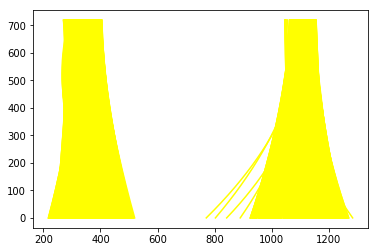

In [43]:
output_video = 'project_video.mp4'
## You may also uncomment the following line for a subclip of specification
clip1 = VideoFileClip(output_video)#.subclip(39,45)
first_window = True
left_fit = np.zeros(3)
right_fit = np.zeros(3)
white_clip = clip1.fl_image(ProcessImage) 
%time white_clip.write_videofile('final_output_video.mp4', audio=False)

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_clip))